In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

import xgboost as xgb
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
import shap
shap.initjs()

In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

In [7]:
train_dataset

<NumpyDataset X.shape: (390, 129), y.shape: (390,), w.shape: (390,), ids: [206 477 392 ... 38 327 261], task_names: [0]>

In [8]:
data_maccs_mask = vt.get_support(indices=True)

# GridSearchCV

In [9]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

param_grid = {'n_estimators':[200],
                  'max_depth':[3,5,7,9],
                  'colsample_bytree':[0.5,0.7,0.9],
                 'learning_rate':[0.01,0.05, 0.1,0.15,0.2]
                 }
    
xgb_classifier = xgb.XGBClassifier()


gs = GridSearchCV(
                   xgb_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [10]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

# GridSearchCV_Result

In [11]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Best score (AUC):  0.9265368389883228
ACC:  0.8538461538461538
PRE:  0.8431799147430528
REC:  0.8707080046553731


In [12]:
xgb_model = gs_fit.best_estimator_
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Evaluate model

In [13]:
y_test_pred_proba = xgb_model.predict_proba(test_dataset.X)
y_test_pred = xgb_model.predict(test_dataset.X)

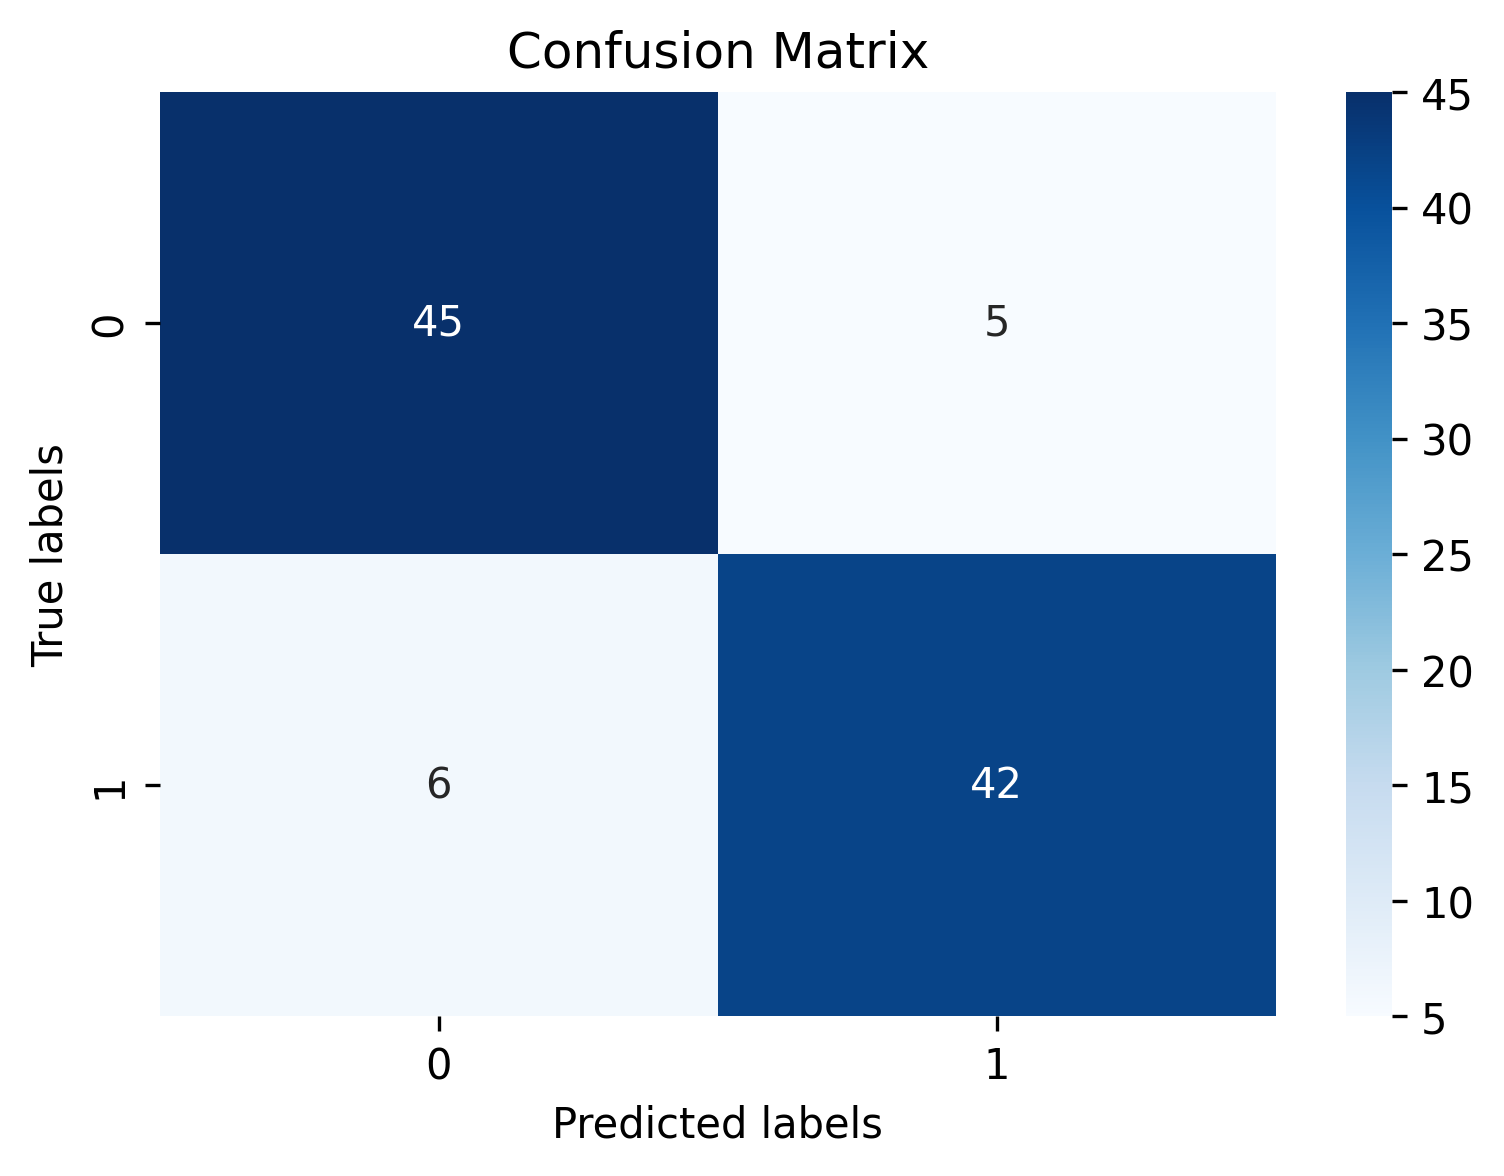

In [14]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [15]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [16]:
test_pred_array = np.array(test_pred_list)

In [17]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

# Finall result

In [18]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [19]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

AUC       ACC       PRE       REC
val   0.926537  0.853846  0.843180  0.870708
test  0.972500  0.887755  0.893617  0.875000

In [20]:
import pickle


with open('xgb_maccs_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Ave_confusion_matrix

In [21]:
confusion_mat_ave = np.array([[41.6,5.6],[5.6,45.2]])

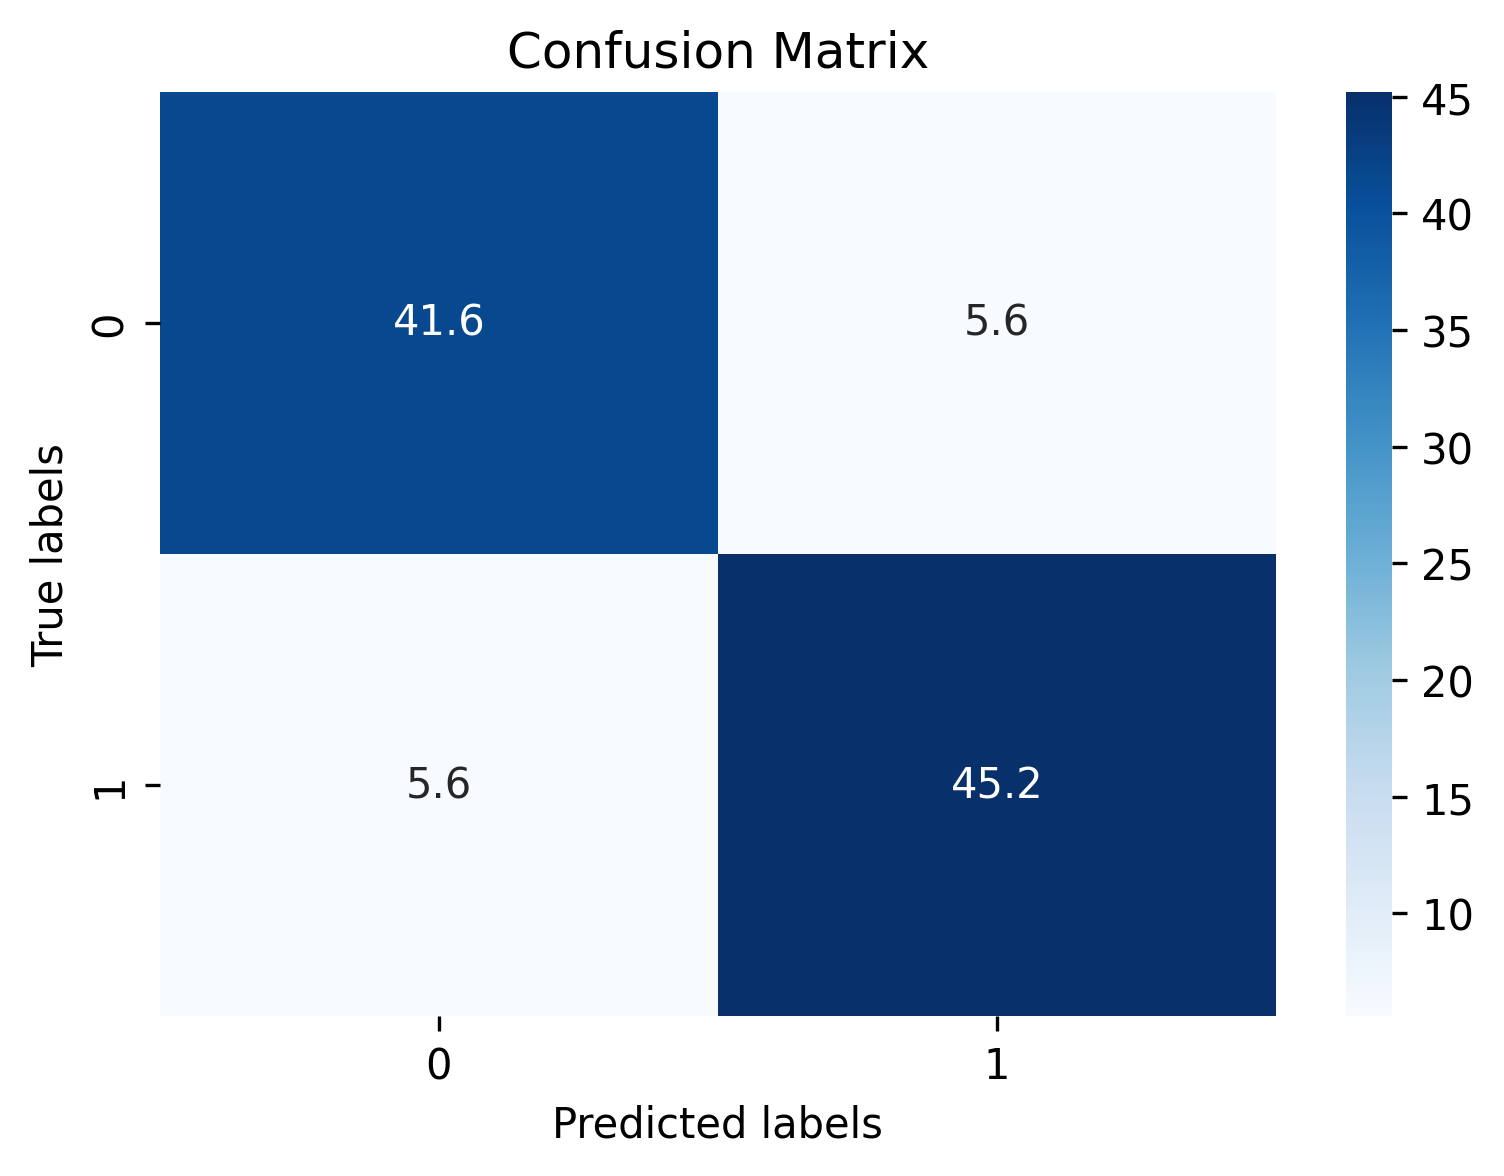

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# SHAP

In [20]:
MACCS = pd.read_csv('../../data/MACCS.csv',encoding='gb18030')
result = [MACCS['REMARK'][i-1] for i in data_maccs_mask]

In [21]:
explainer = shap.TreeExplainer(xgb_model,feature_names=result)
shap_values = explainer(test_dataset.X)

In [22]:
test_data = pd.DataFrame(test_dataset.X, columns=result)

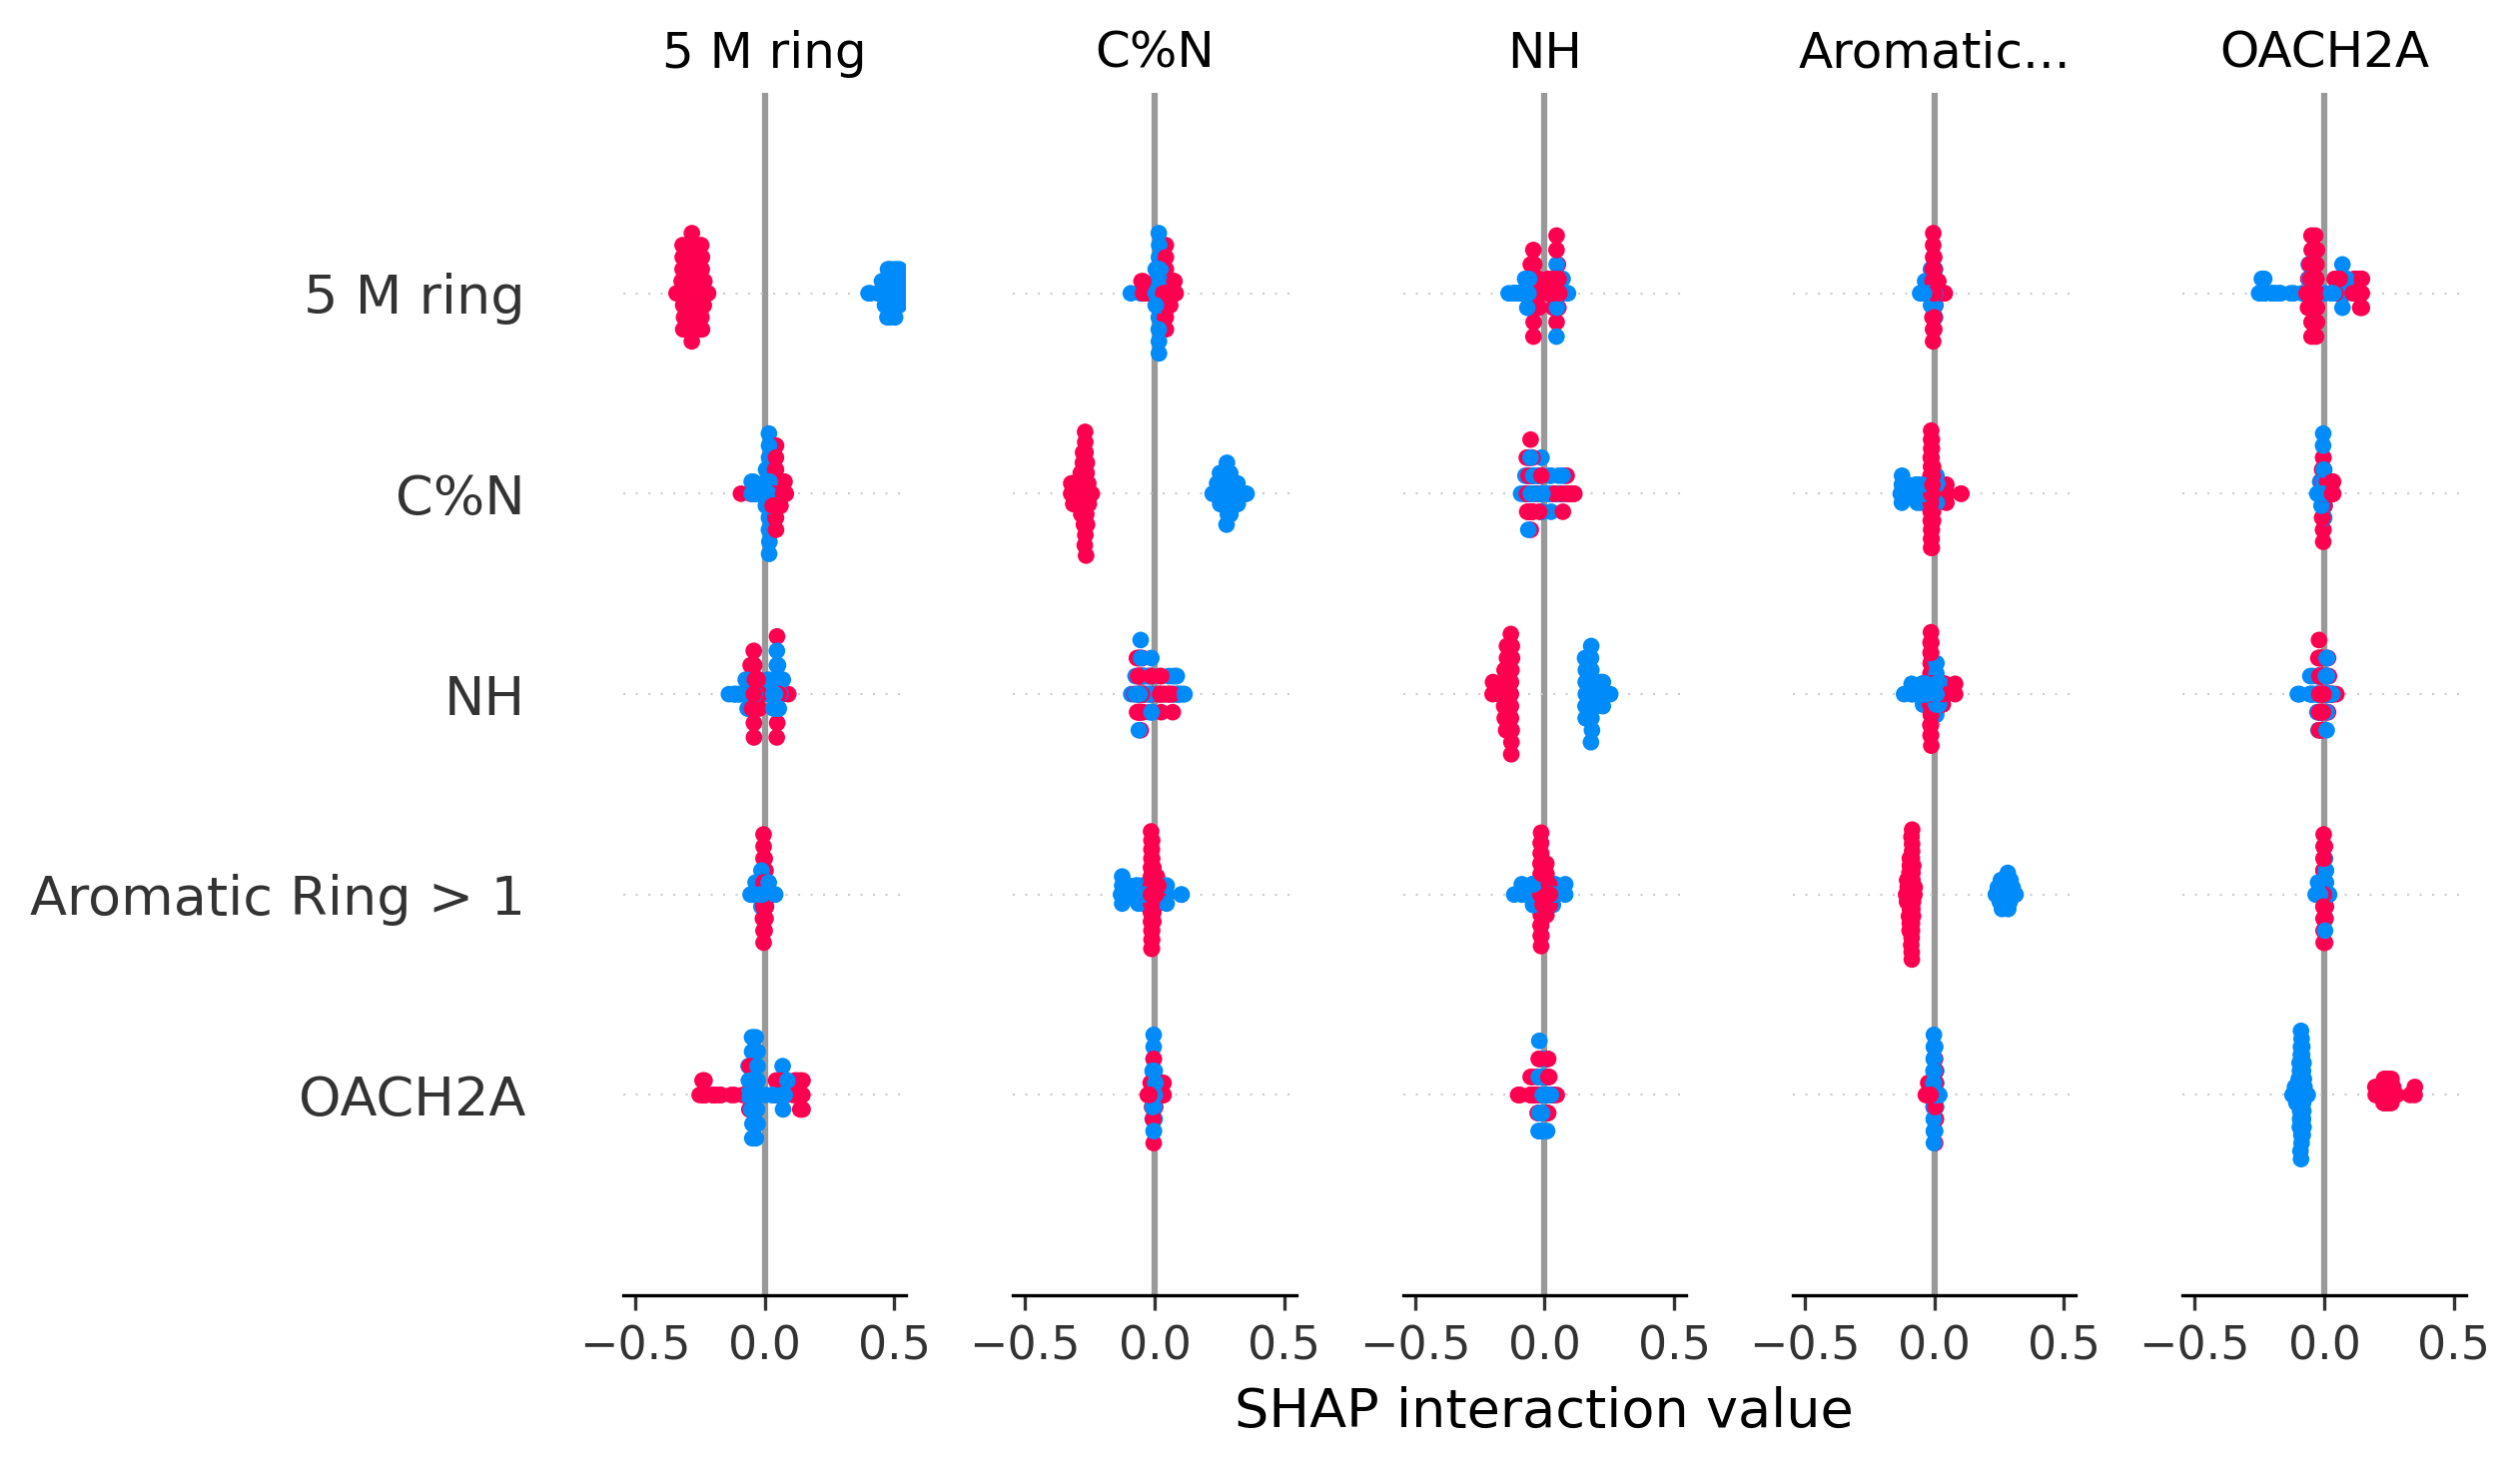

In [23]:
shap_interaction_values = explainer.shap_interaction_values(test_dataset.X)
shap.summary_plot(shap_interaction_values,test_data, max_display=5,show=False)
plt.tight_layout()
plt.show()

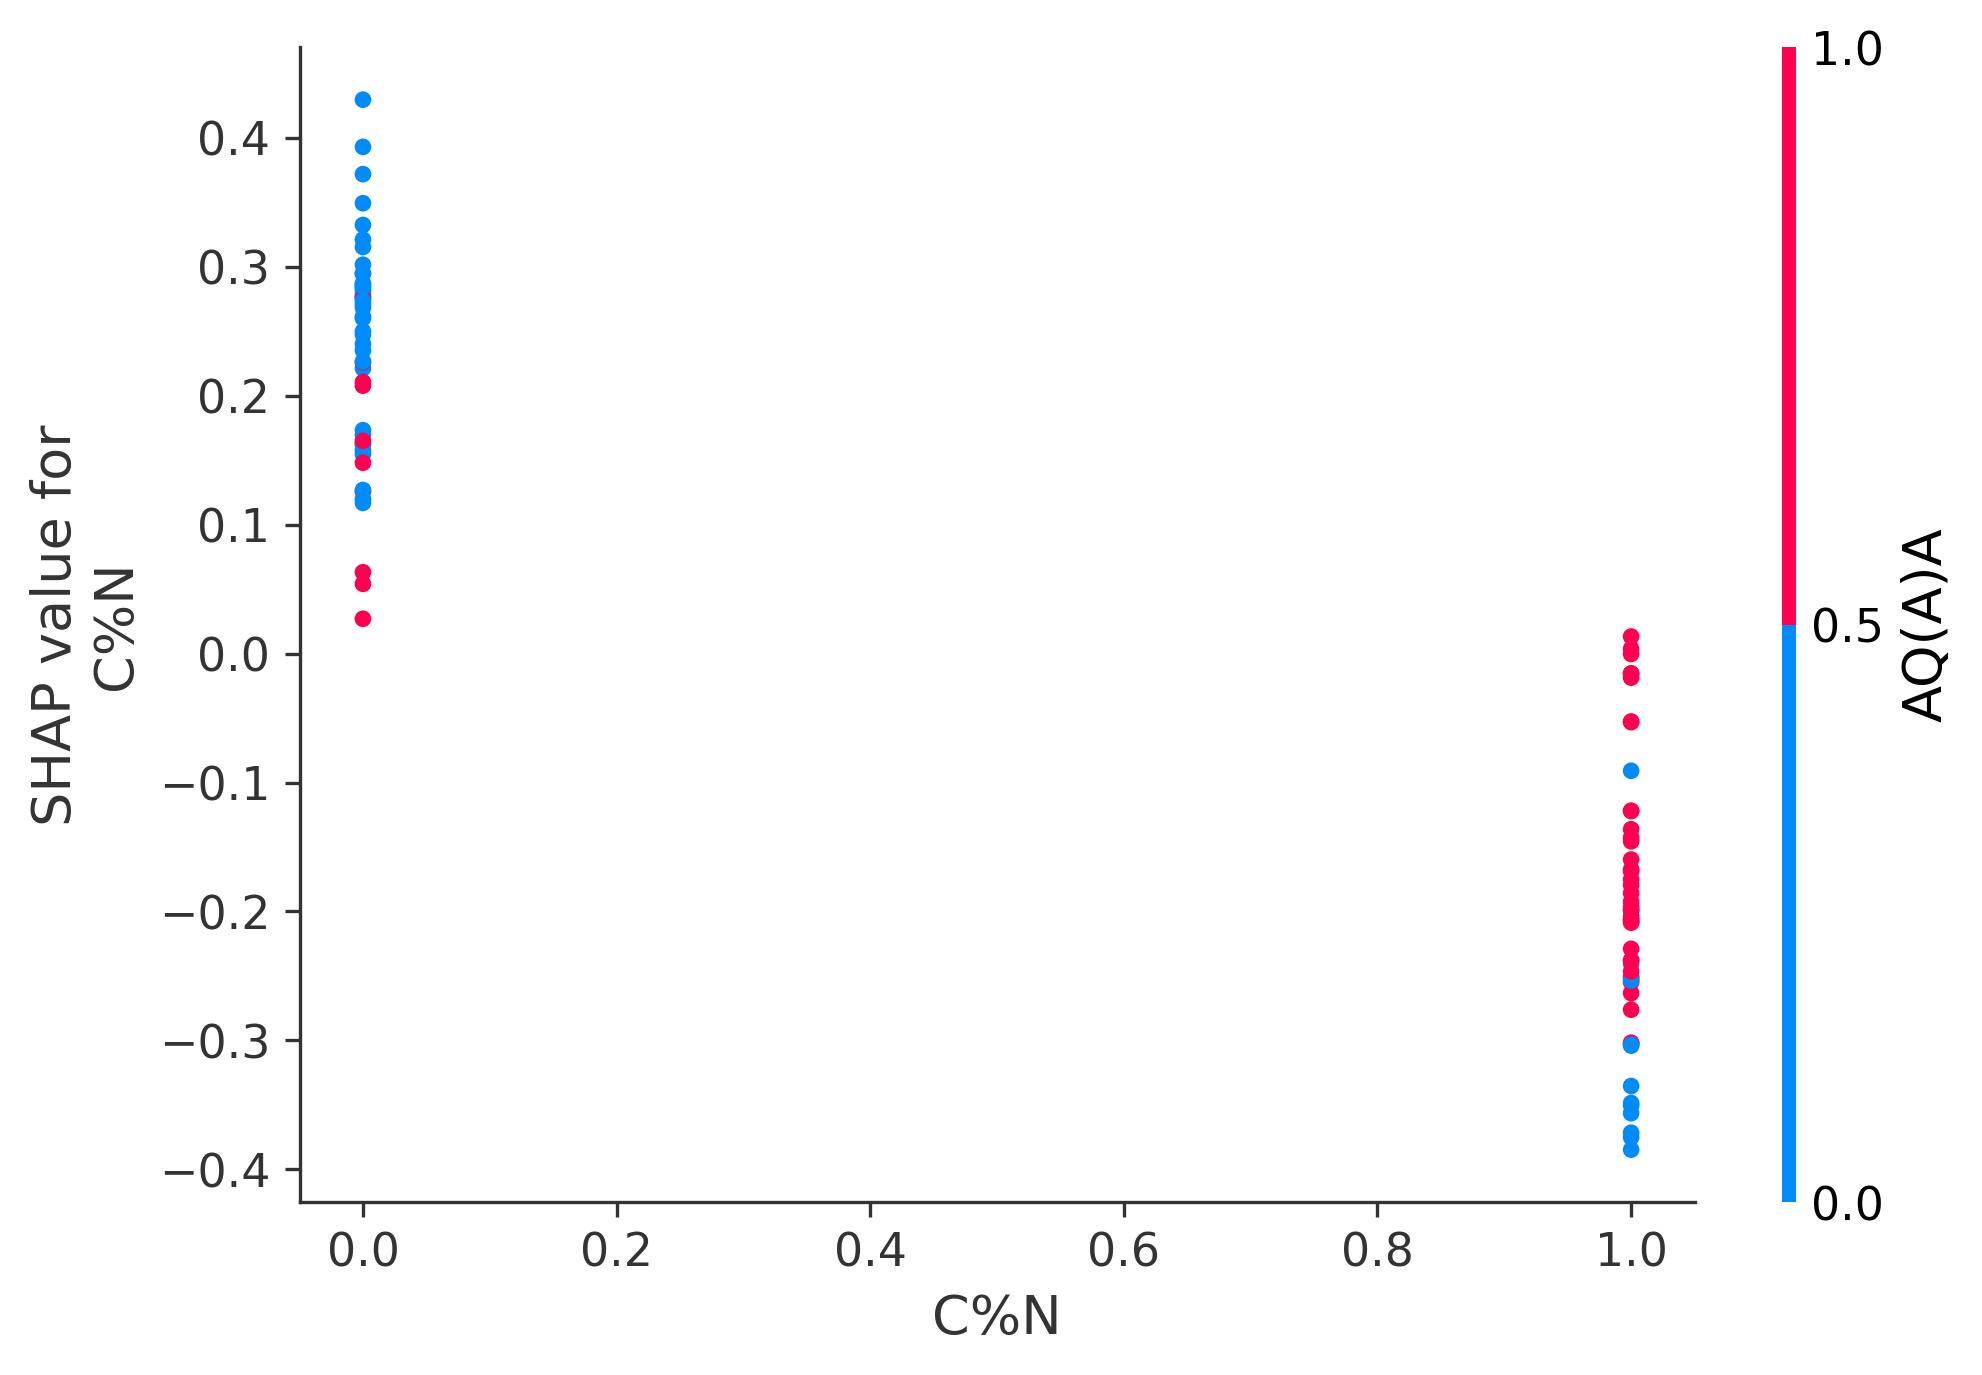

In [25]:
shap_values_array = shap_values.values
shap.dependence_plot("C%N", shap_values_array, test_dataset.X, feature_names=result, display_features=test_dataset.X)

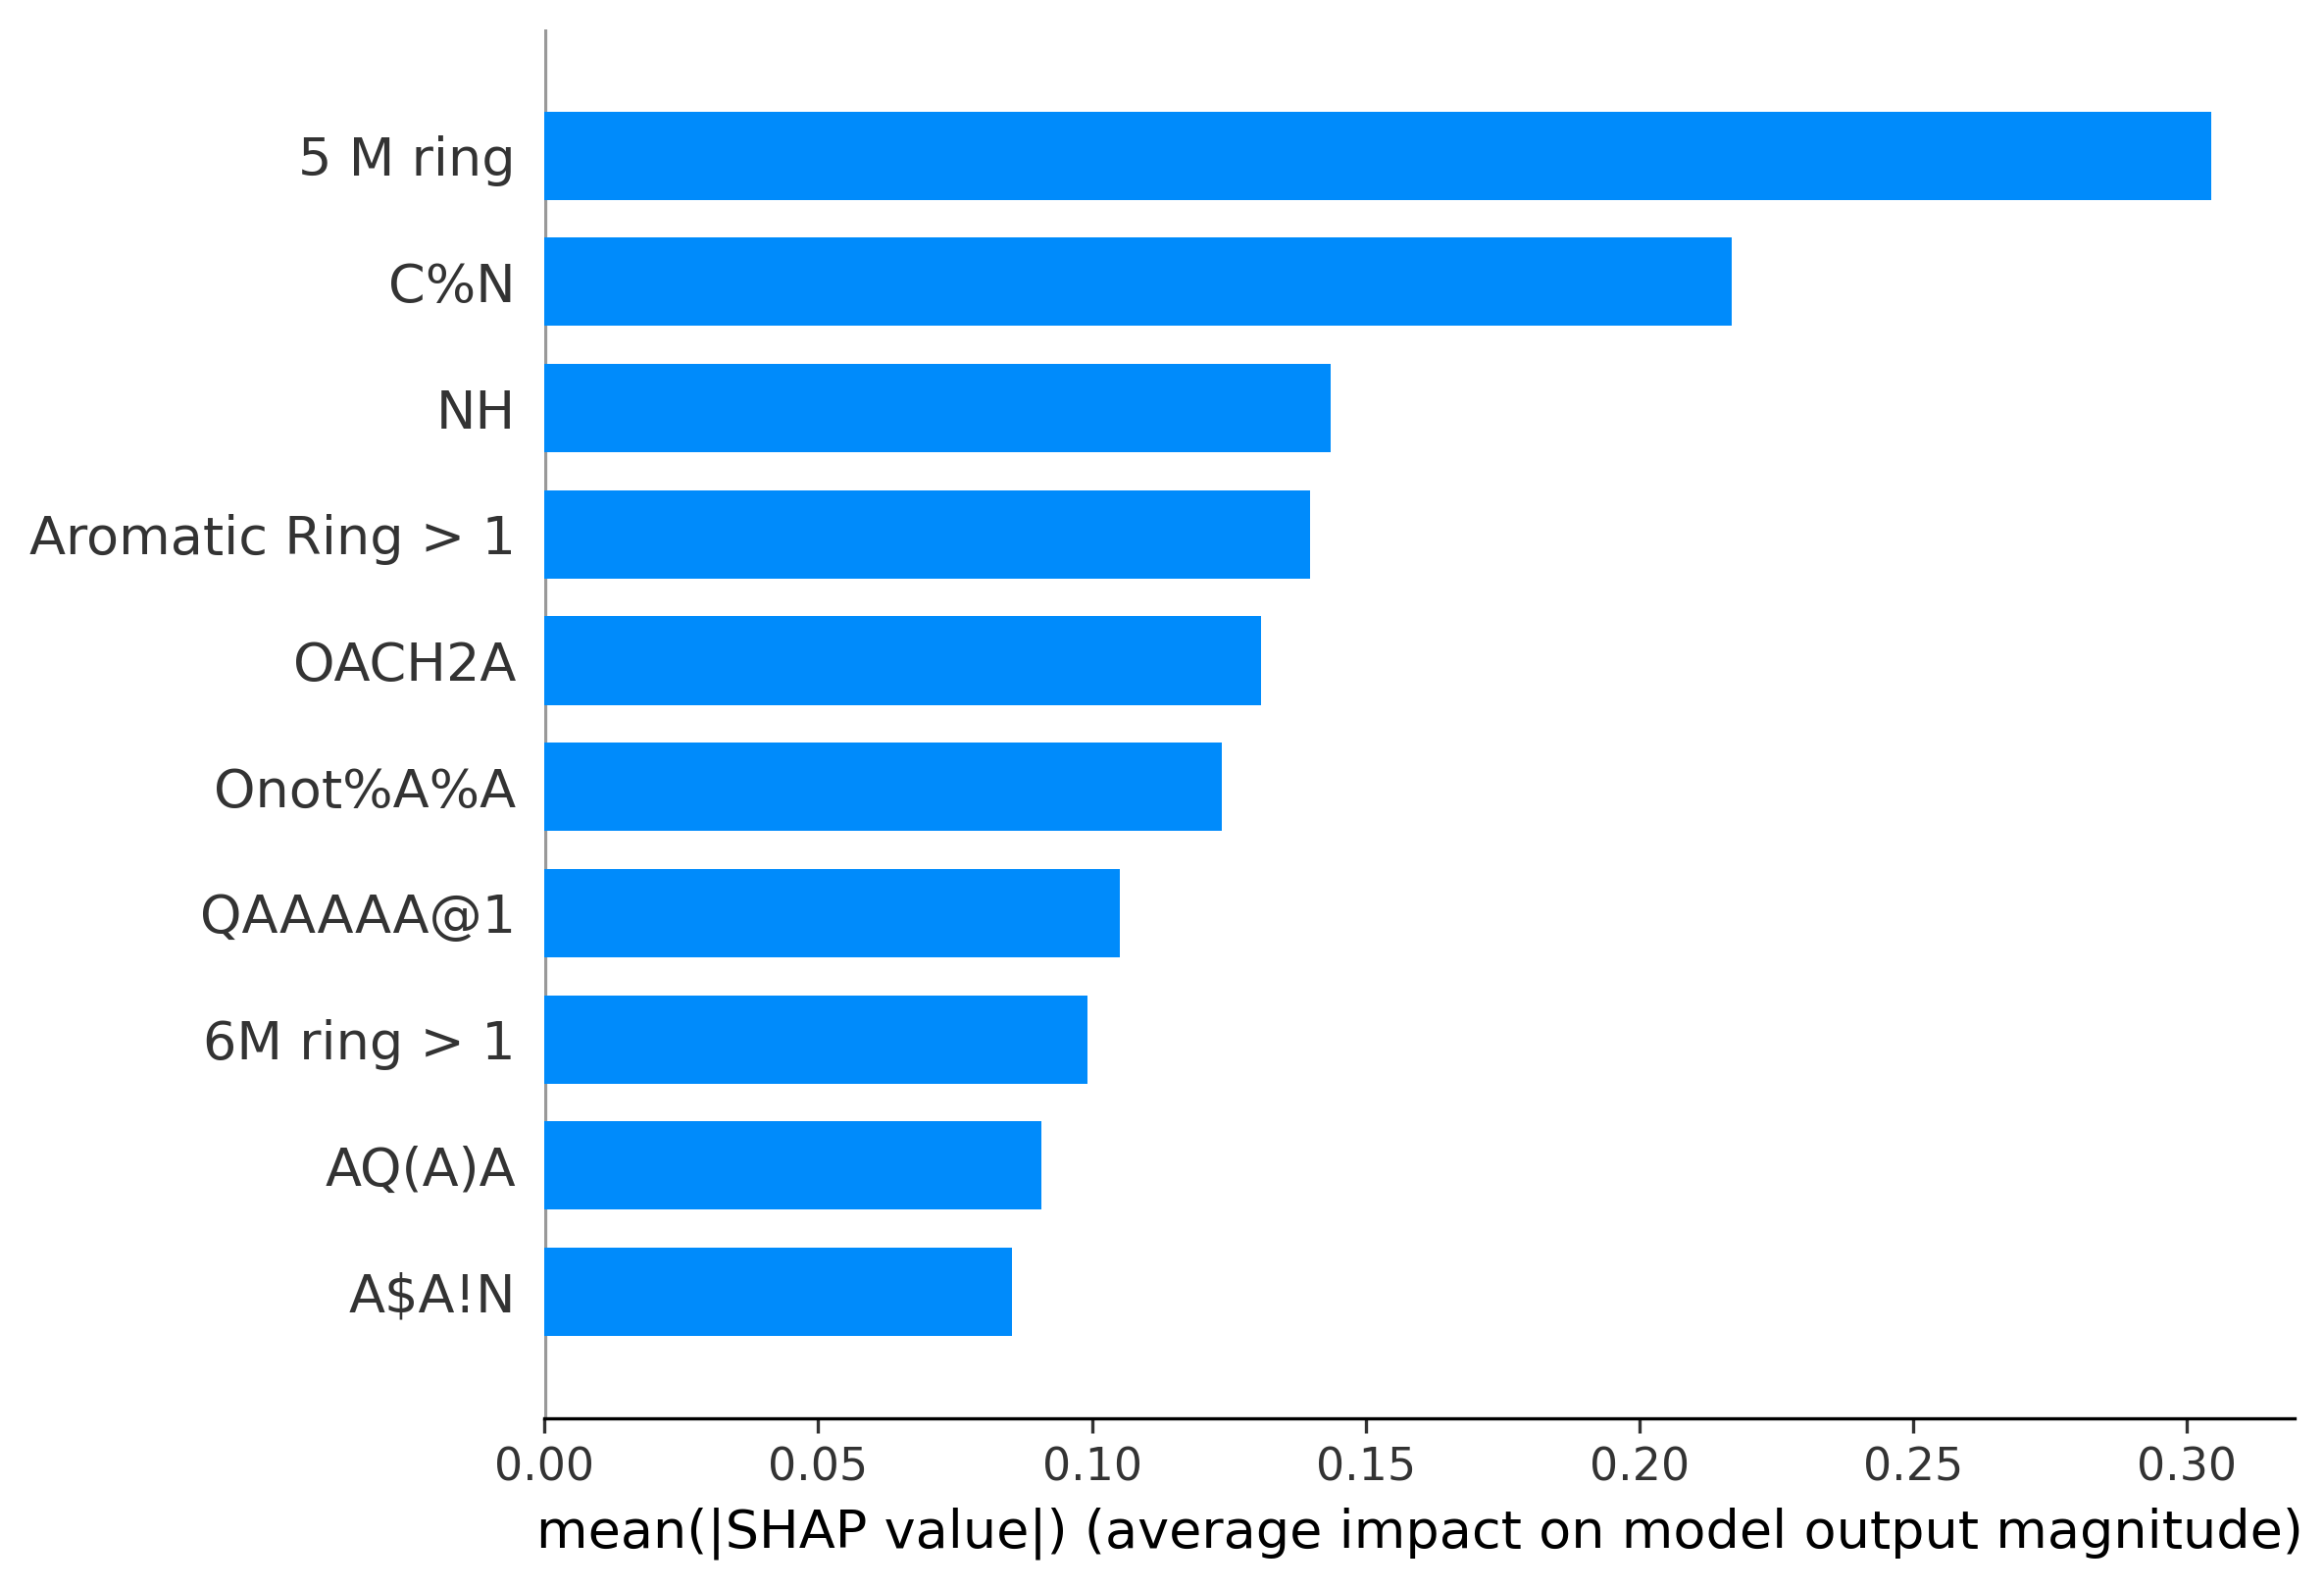

In [38]:
shap.summary_plot(shap_values, test_dataset.X, plot_type="bar", max_display=10,feature_names = result)

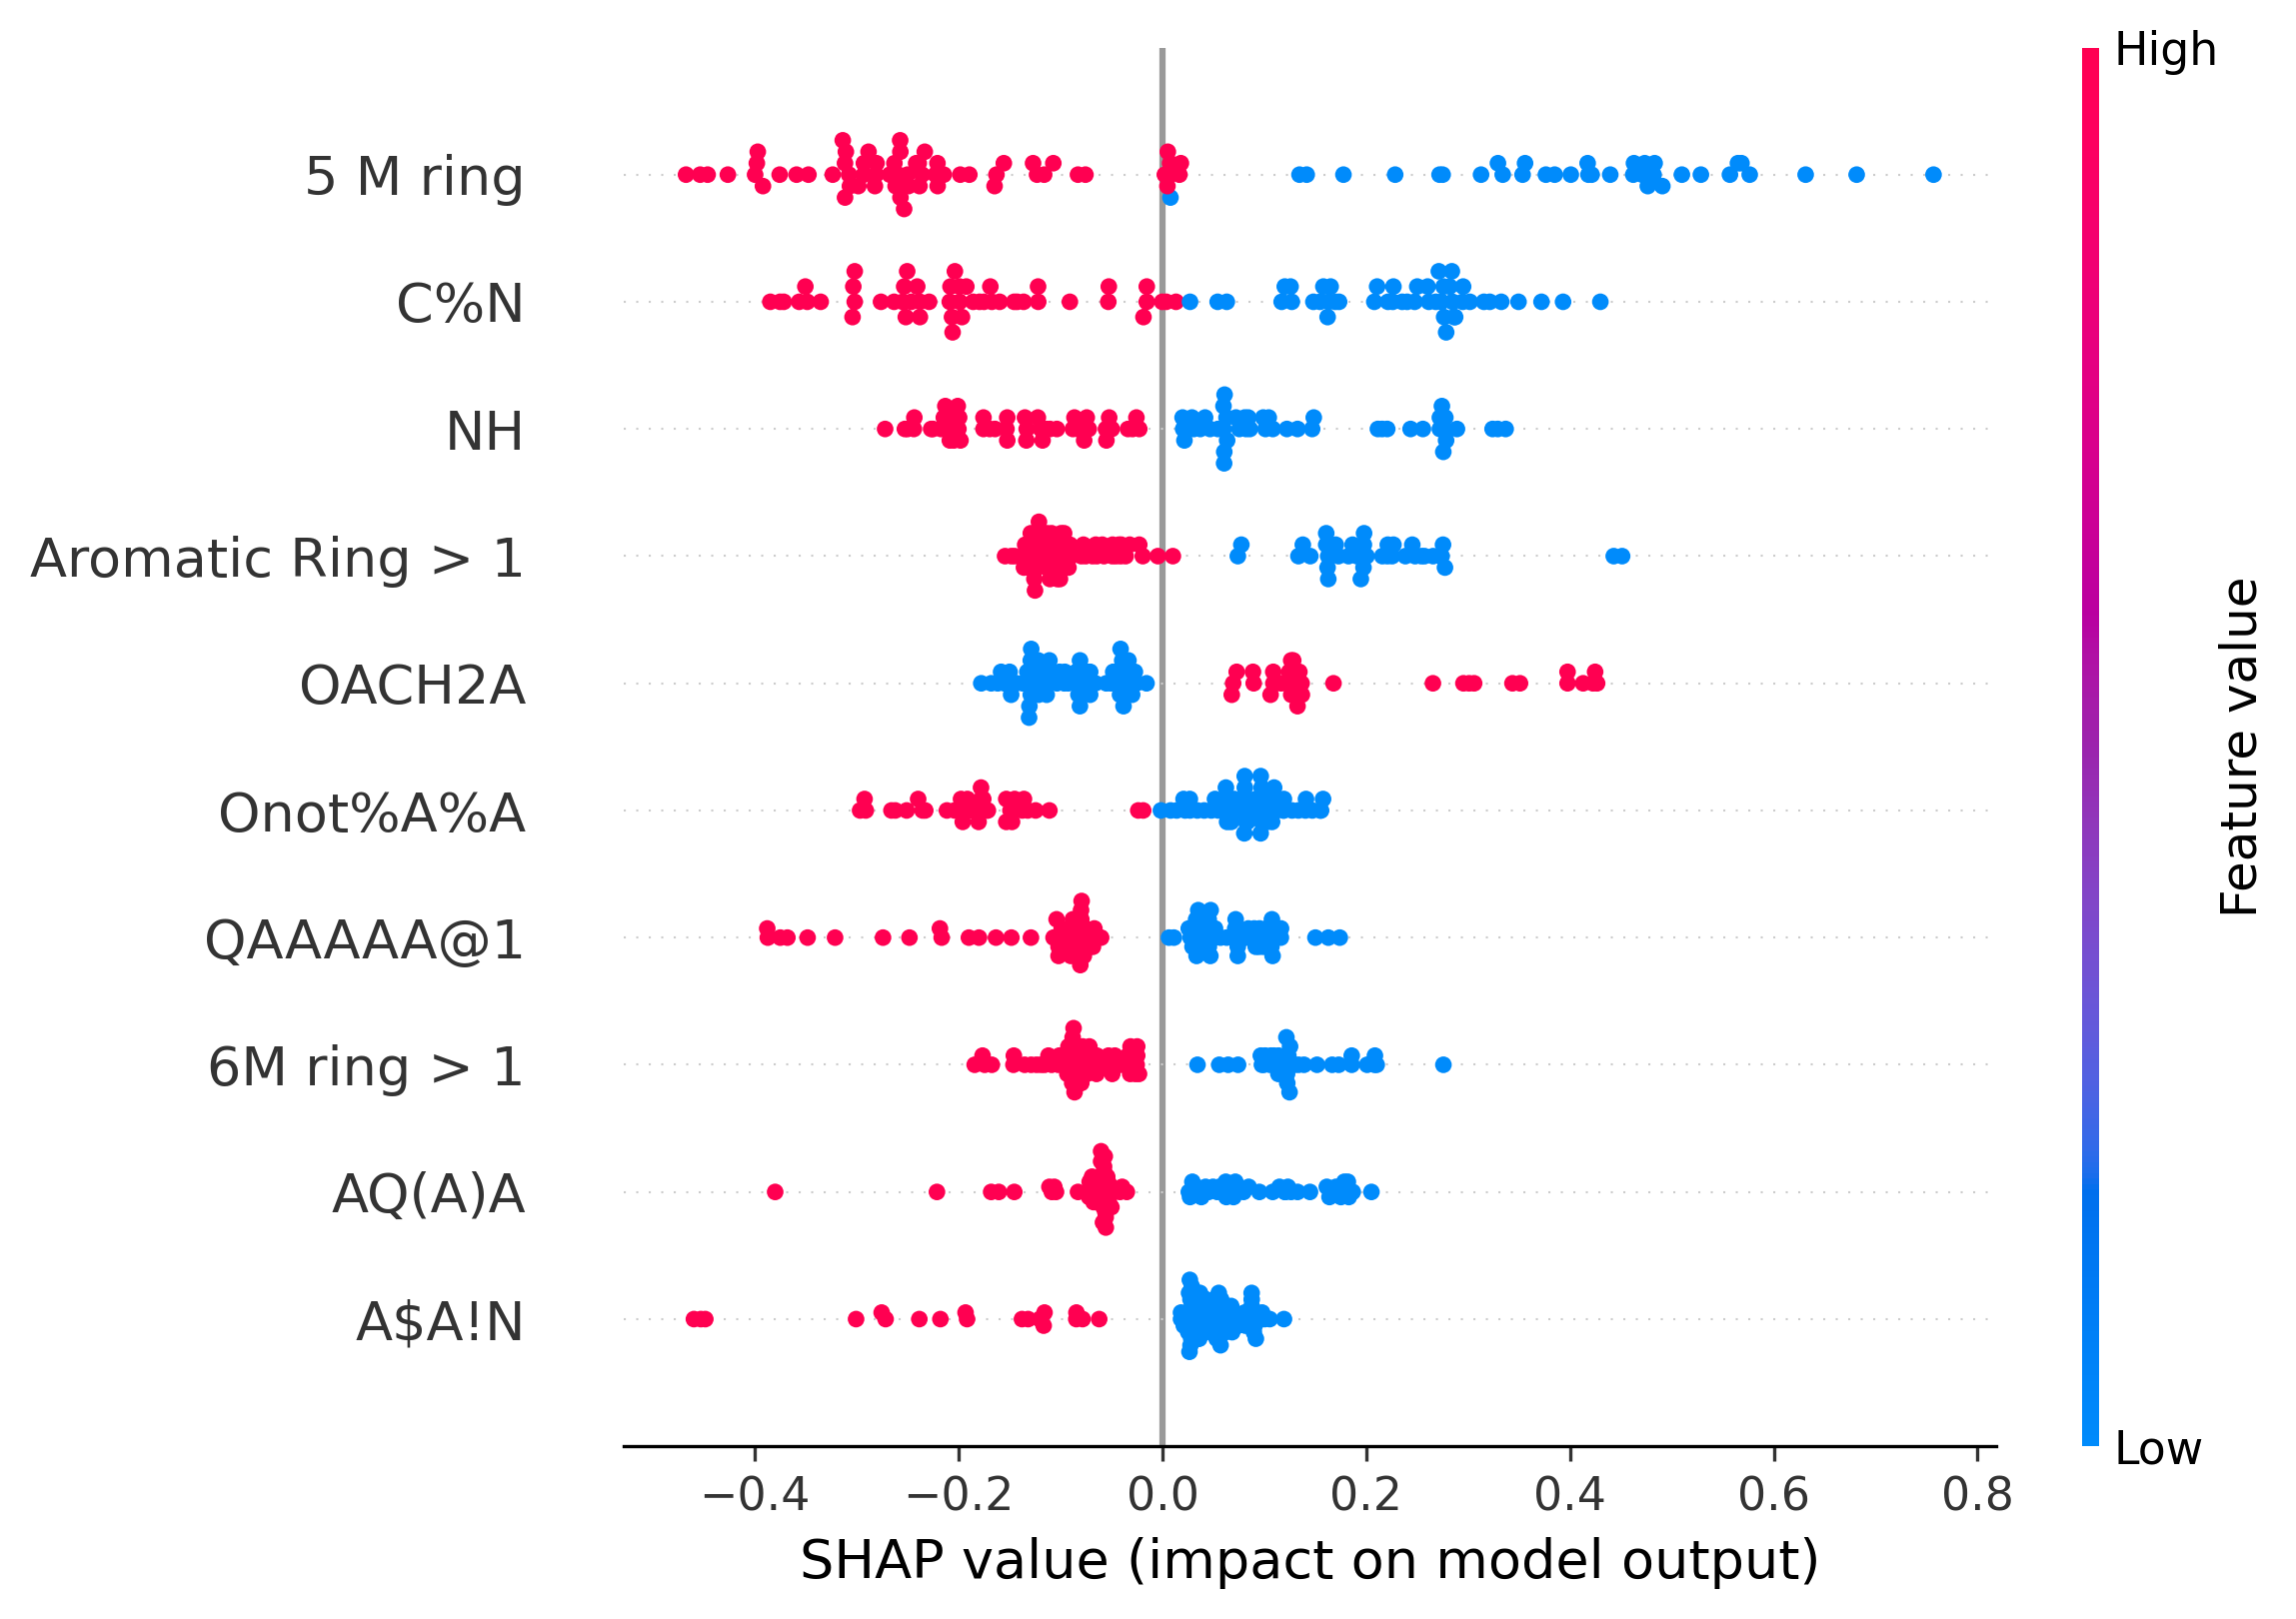

In [39]:
shap.summary_plot(shap_values, test_dataset.X,max_display=10,feature_names = result)

In [40]:
expected_values = explainer.expected_value

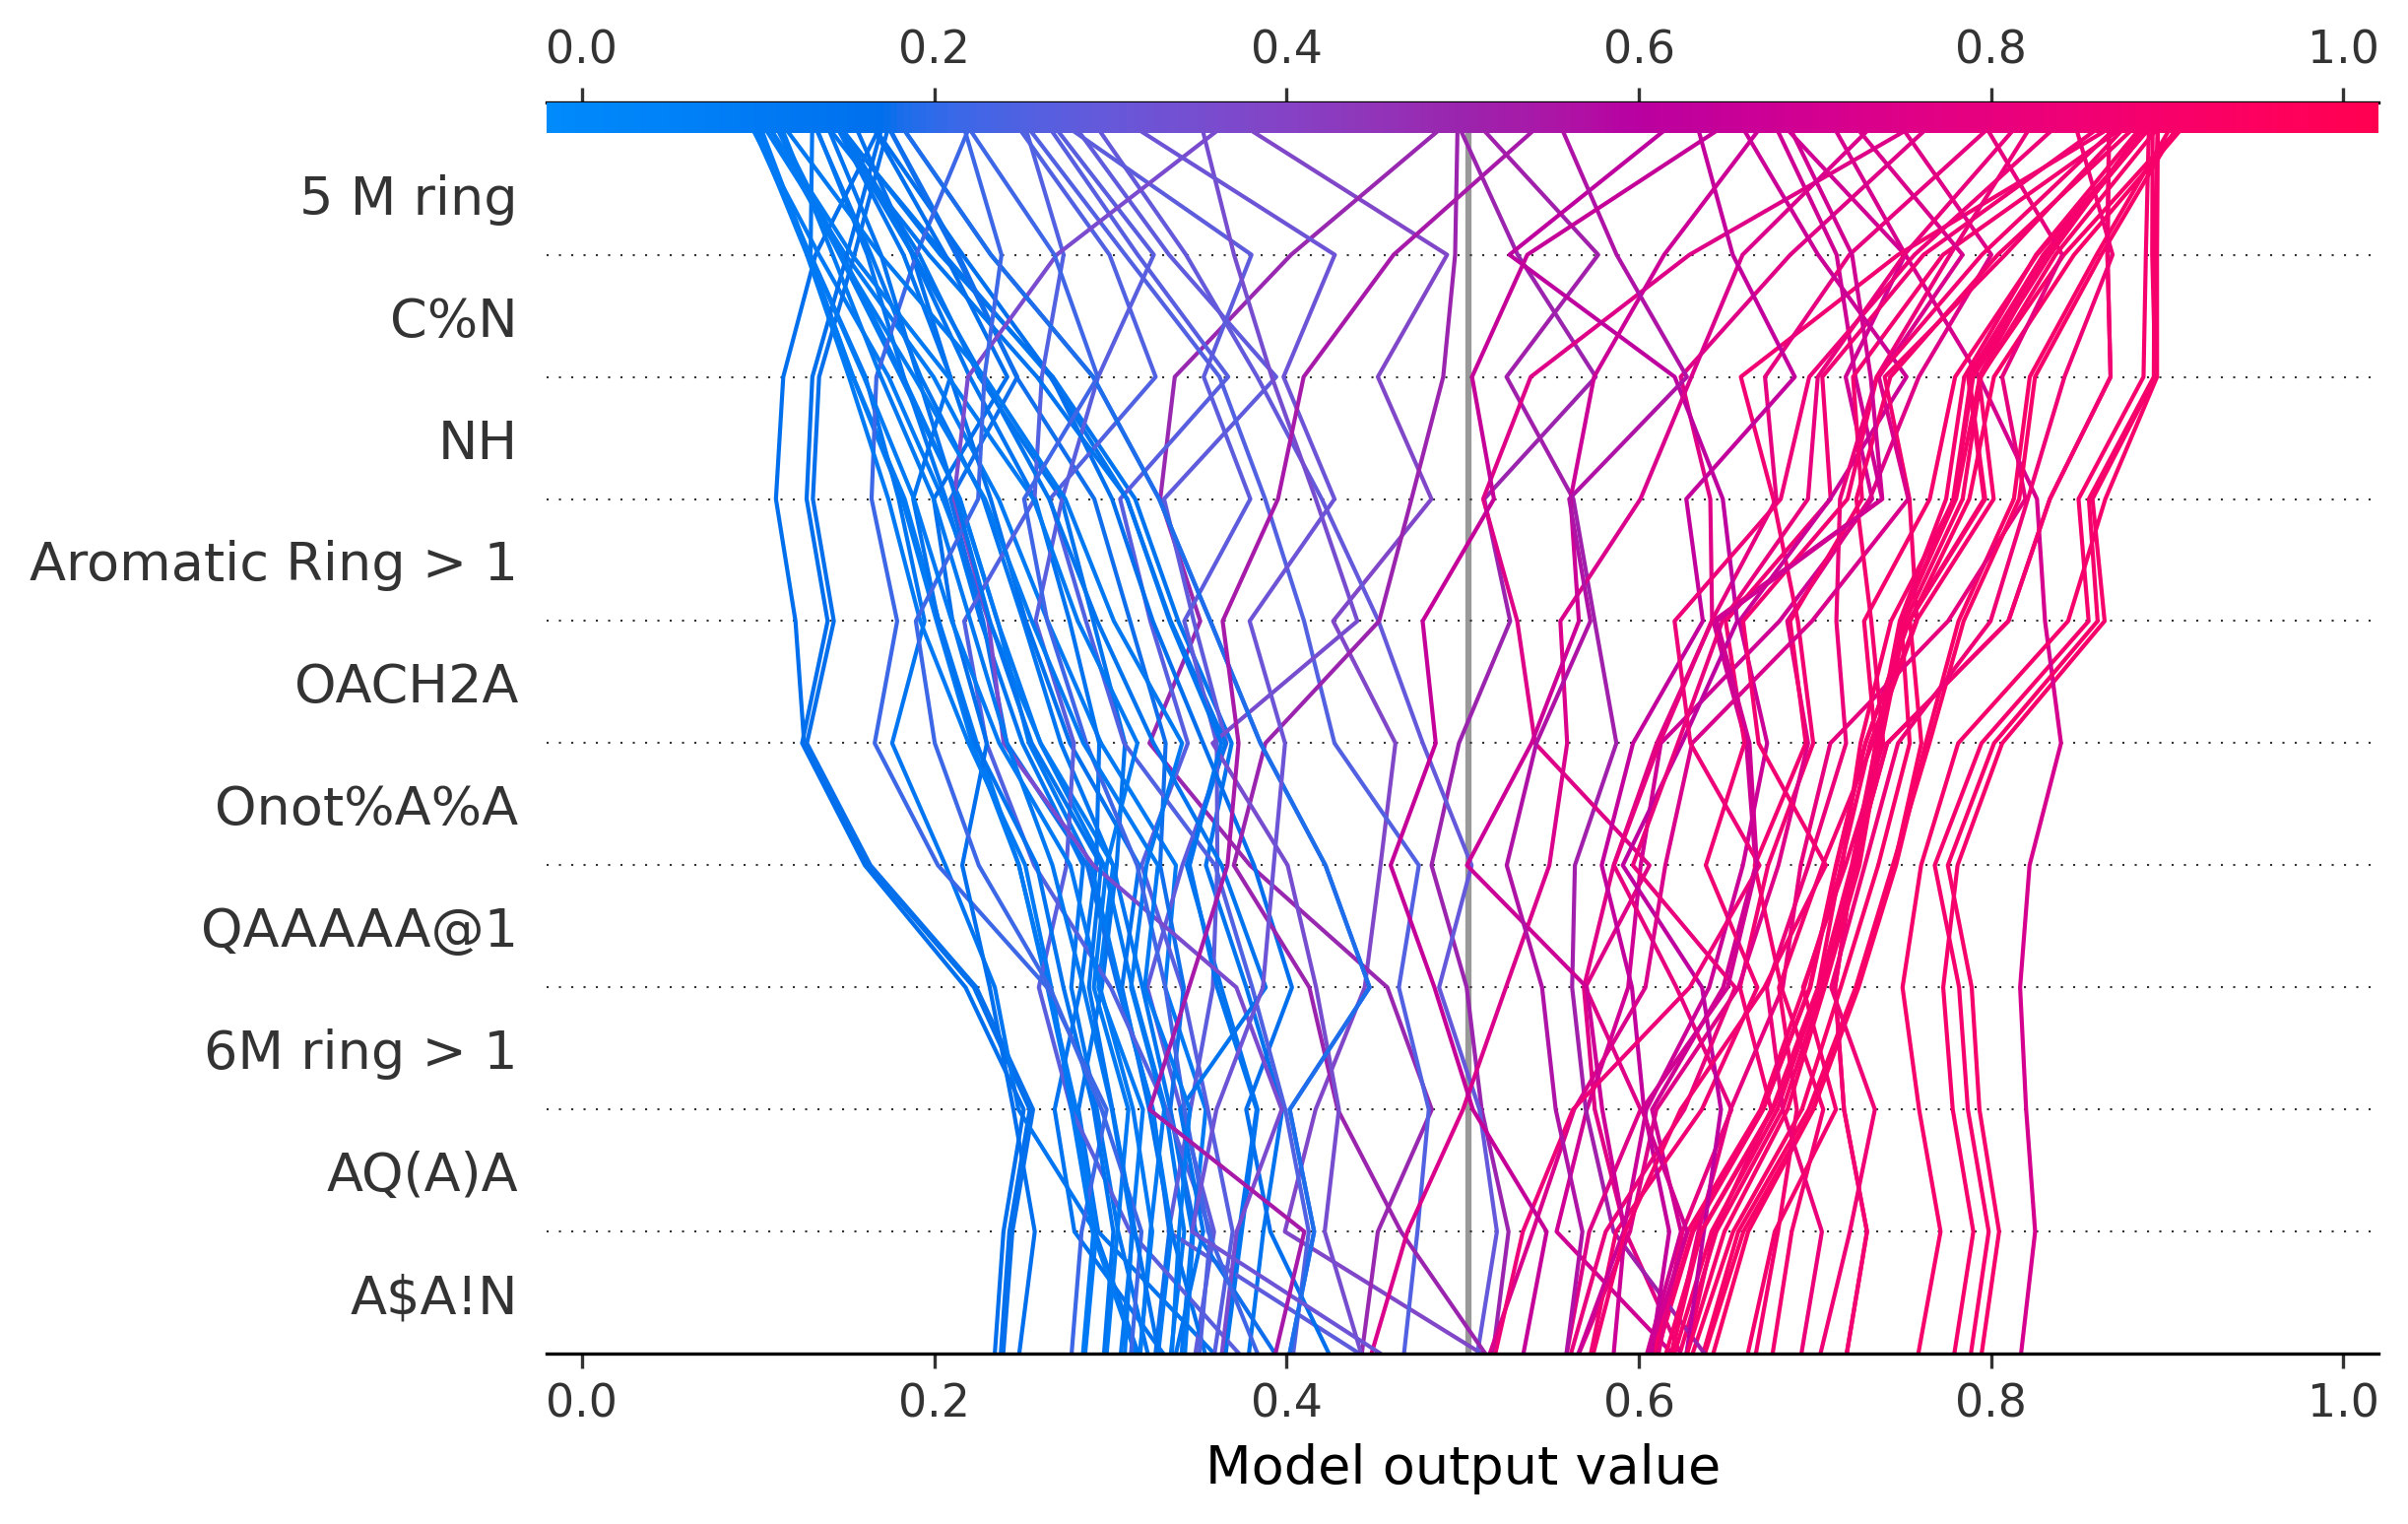

In [42]:
shap.decision_plot(expected_values, shap_values_array, test_dataset.X, feature_names = result,link='logit',feature_display_range=slice(None,-11,-1))

In [43]:
y_test_pred_proba[0:10]

array([[0.61816514, 0.3818349 ],
       [0.86609924, 0.13390075],
       [0.11050516, 0.88949484],
       [0.10832083, 0.89167917],
       [0.8944968 , 0.10550322],
       [0.85168684, 0.14831318],
       [0.5152004 , 0.48479962],
       [0.83247864, 0.16752134],
       [0.09981269, 0.9001873 ],
       [0.11342365, 0.88657635]], dtype=float32)

# global_force_plot

In [26]:
shap.force_plot(explainer.expected_value, shap_values_array,test_dataset.X,feature_names = result)

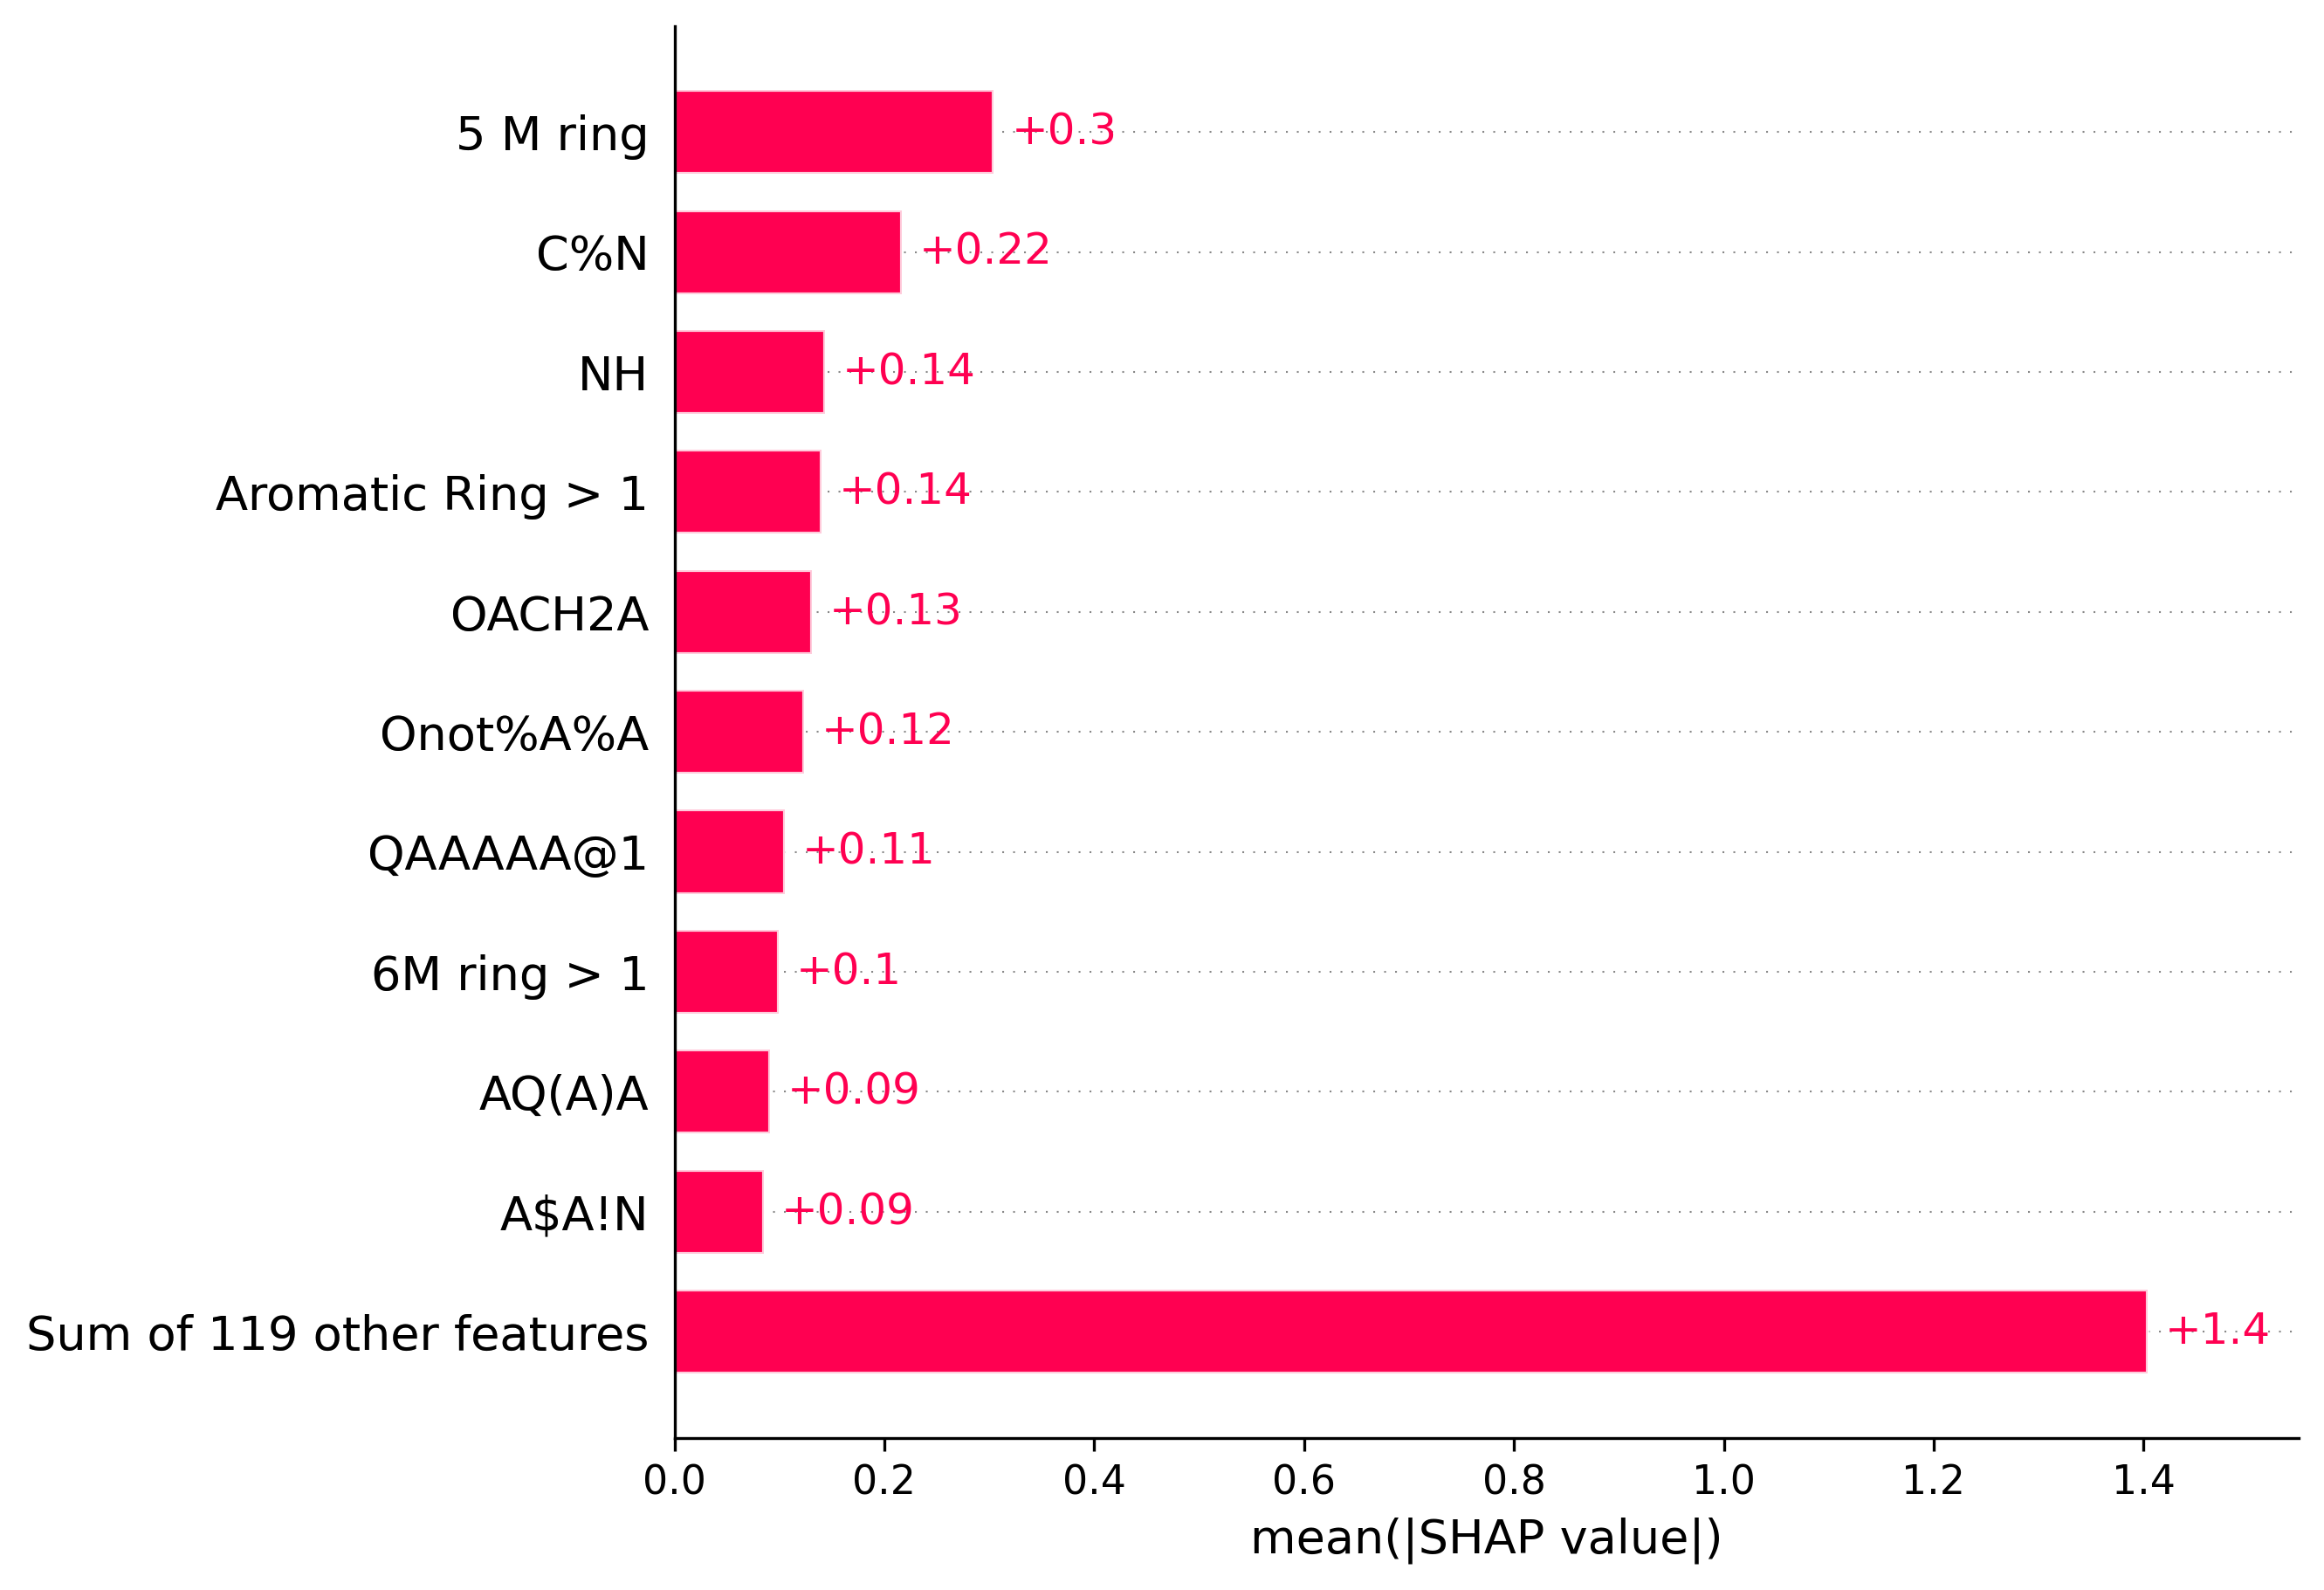

In [46]:
explainer2 = shap.Explainer(xgb_model,feature_names = result)
shap_values2 = explainer2(test_dataset.X)
shap.plots.bar(shap_values2,  max_display=11)

# plot_experimental_compounds

In [59]:
exp_compounds = pd.read_excel('../../data/Experimental compounds.xlsx')

In [60]:
exp_compounds_featrures = featurizer.featurize(exp_compounds['SMILES'])

In [61]:
mask = vt.get_support(indices=True)
exp_compounds_selected = exp_compounds_featrures[:, mask]

In [62]:
exp_compounds_prob = xgb_model.predict_proba(exp_compounds_selected)

In [63]:
exp_compounds_prob[0:1]

array([[0.11759806, 0.88240194]], dtype=float32)

In [64]:
# 计算 SHAP 值
shap_values2 = explainer(exp_compounds_selected)

In [44]:
shap.force_plot(explainer.expected_value, shap_values2.values,exp_compounds_featrures,feature_names = result)

In [65]:
probabilities = exp_compounds_prob[:, 1] 

In [67]:
new_base_values = probabilities - np.sum(shap_values2.values, axis=1)

In [69]:

shap_exp = shap.Explanation(
    values=shap_values2.values, 
    base_values=new_base_values, 
    data=exp_compounds_selected, 
    feature_names=result
)

# Carvacrol

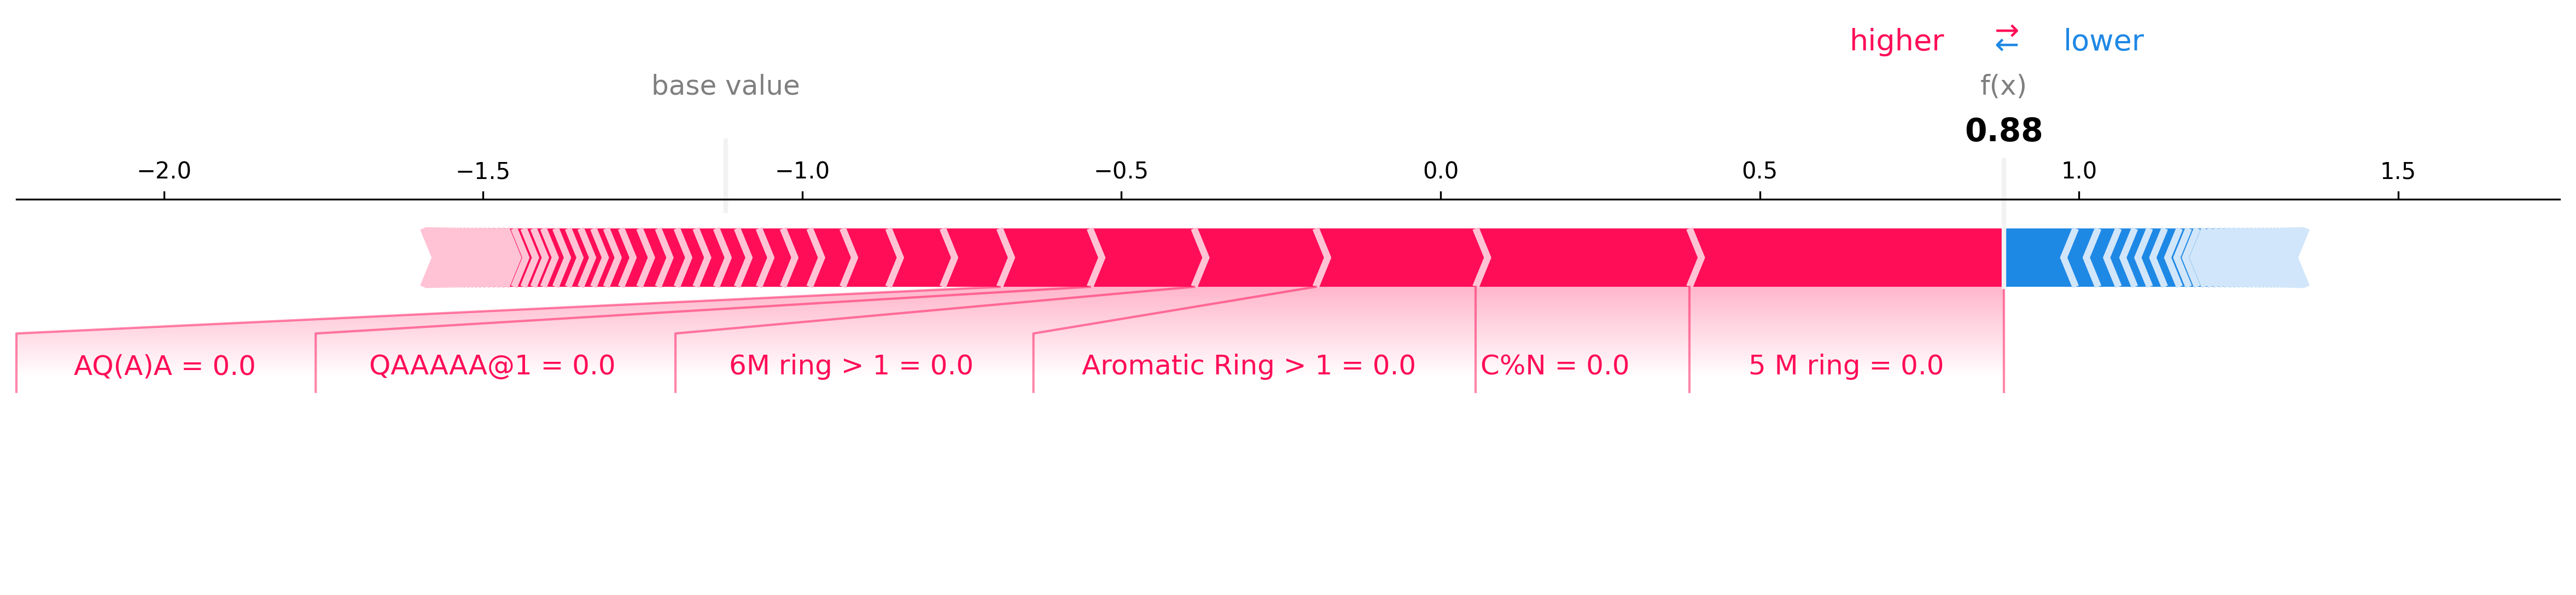

In [70]:
sample = 0  
shap.initjs()
shap.force_plot(
    shap_exp.base_values[sample], 
    shap_exp.values[sample], 
    shap_exp.data[sample], 
    feature_names=result,
    matplotlib=True
)

In [71]:
shap_exp[0]

.values =
array([-6.8931072e-04, -1.4295340e-02,  2.9617283e-03,  0.0000000e+00,
        4.6243420e-04,  0.0000000e+00,  0.0000000e+00,  2.9024435e-04,
        6.0701108e-04,  1.1980071e-03, -1.2051469e-03,  0.0000000e+00,
        9.0399946e-05, -4.1622046e-04, -4.9432216e-04,  5.4603158e-03,
       -4.1792166e-04,  1.7490493e-03,  7.7720718e-03,  1.1810731e-03,
       -4.2904497e-04,  2.8750038e-02,  9.9168438e-04, -6.2910025e-04,
       -1.1697390e-04, -8.4844790e-03, -6.8950641e-05,  3.6465932e-04,
        3.3487859e-01, -2.3305363e-03,  0.0000000e+00,  4.8245615e-03,
       -1.8230242e-04,  3.9676111e-04, -7.9940585e-04,  0.0000000e+00,
        4.1813757e-02,  7.0761293e-03,  2.4123073e-03, -6.8485518e-03,
       -1.3393598e-02, -8.1108026e-03, -2.5432097e-02,  9.5453730e-04,
       -8.1295549e-04,  5.1750630e-02,  6.0813763e-04,  1.9110166e-02,
        5.0194785e-03, -6.2028039e-03, -4.0022476e-04,  7.1437107e-03,
        2.6005071e-03,  2.6024468e-03, -7.5259840e-04,  1.2511574e-

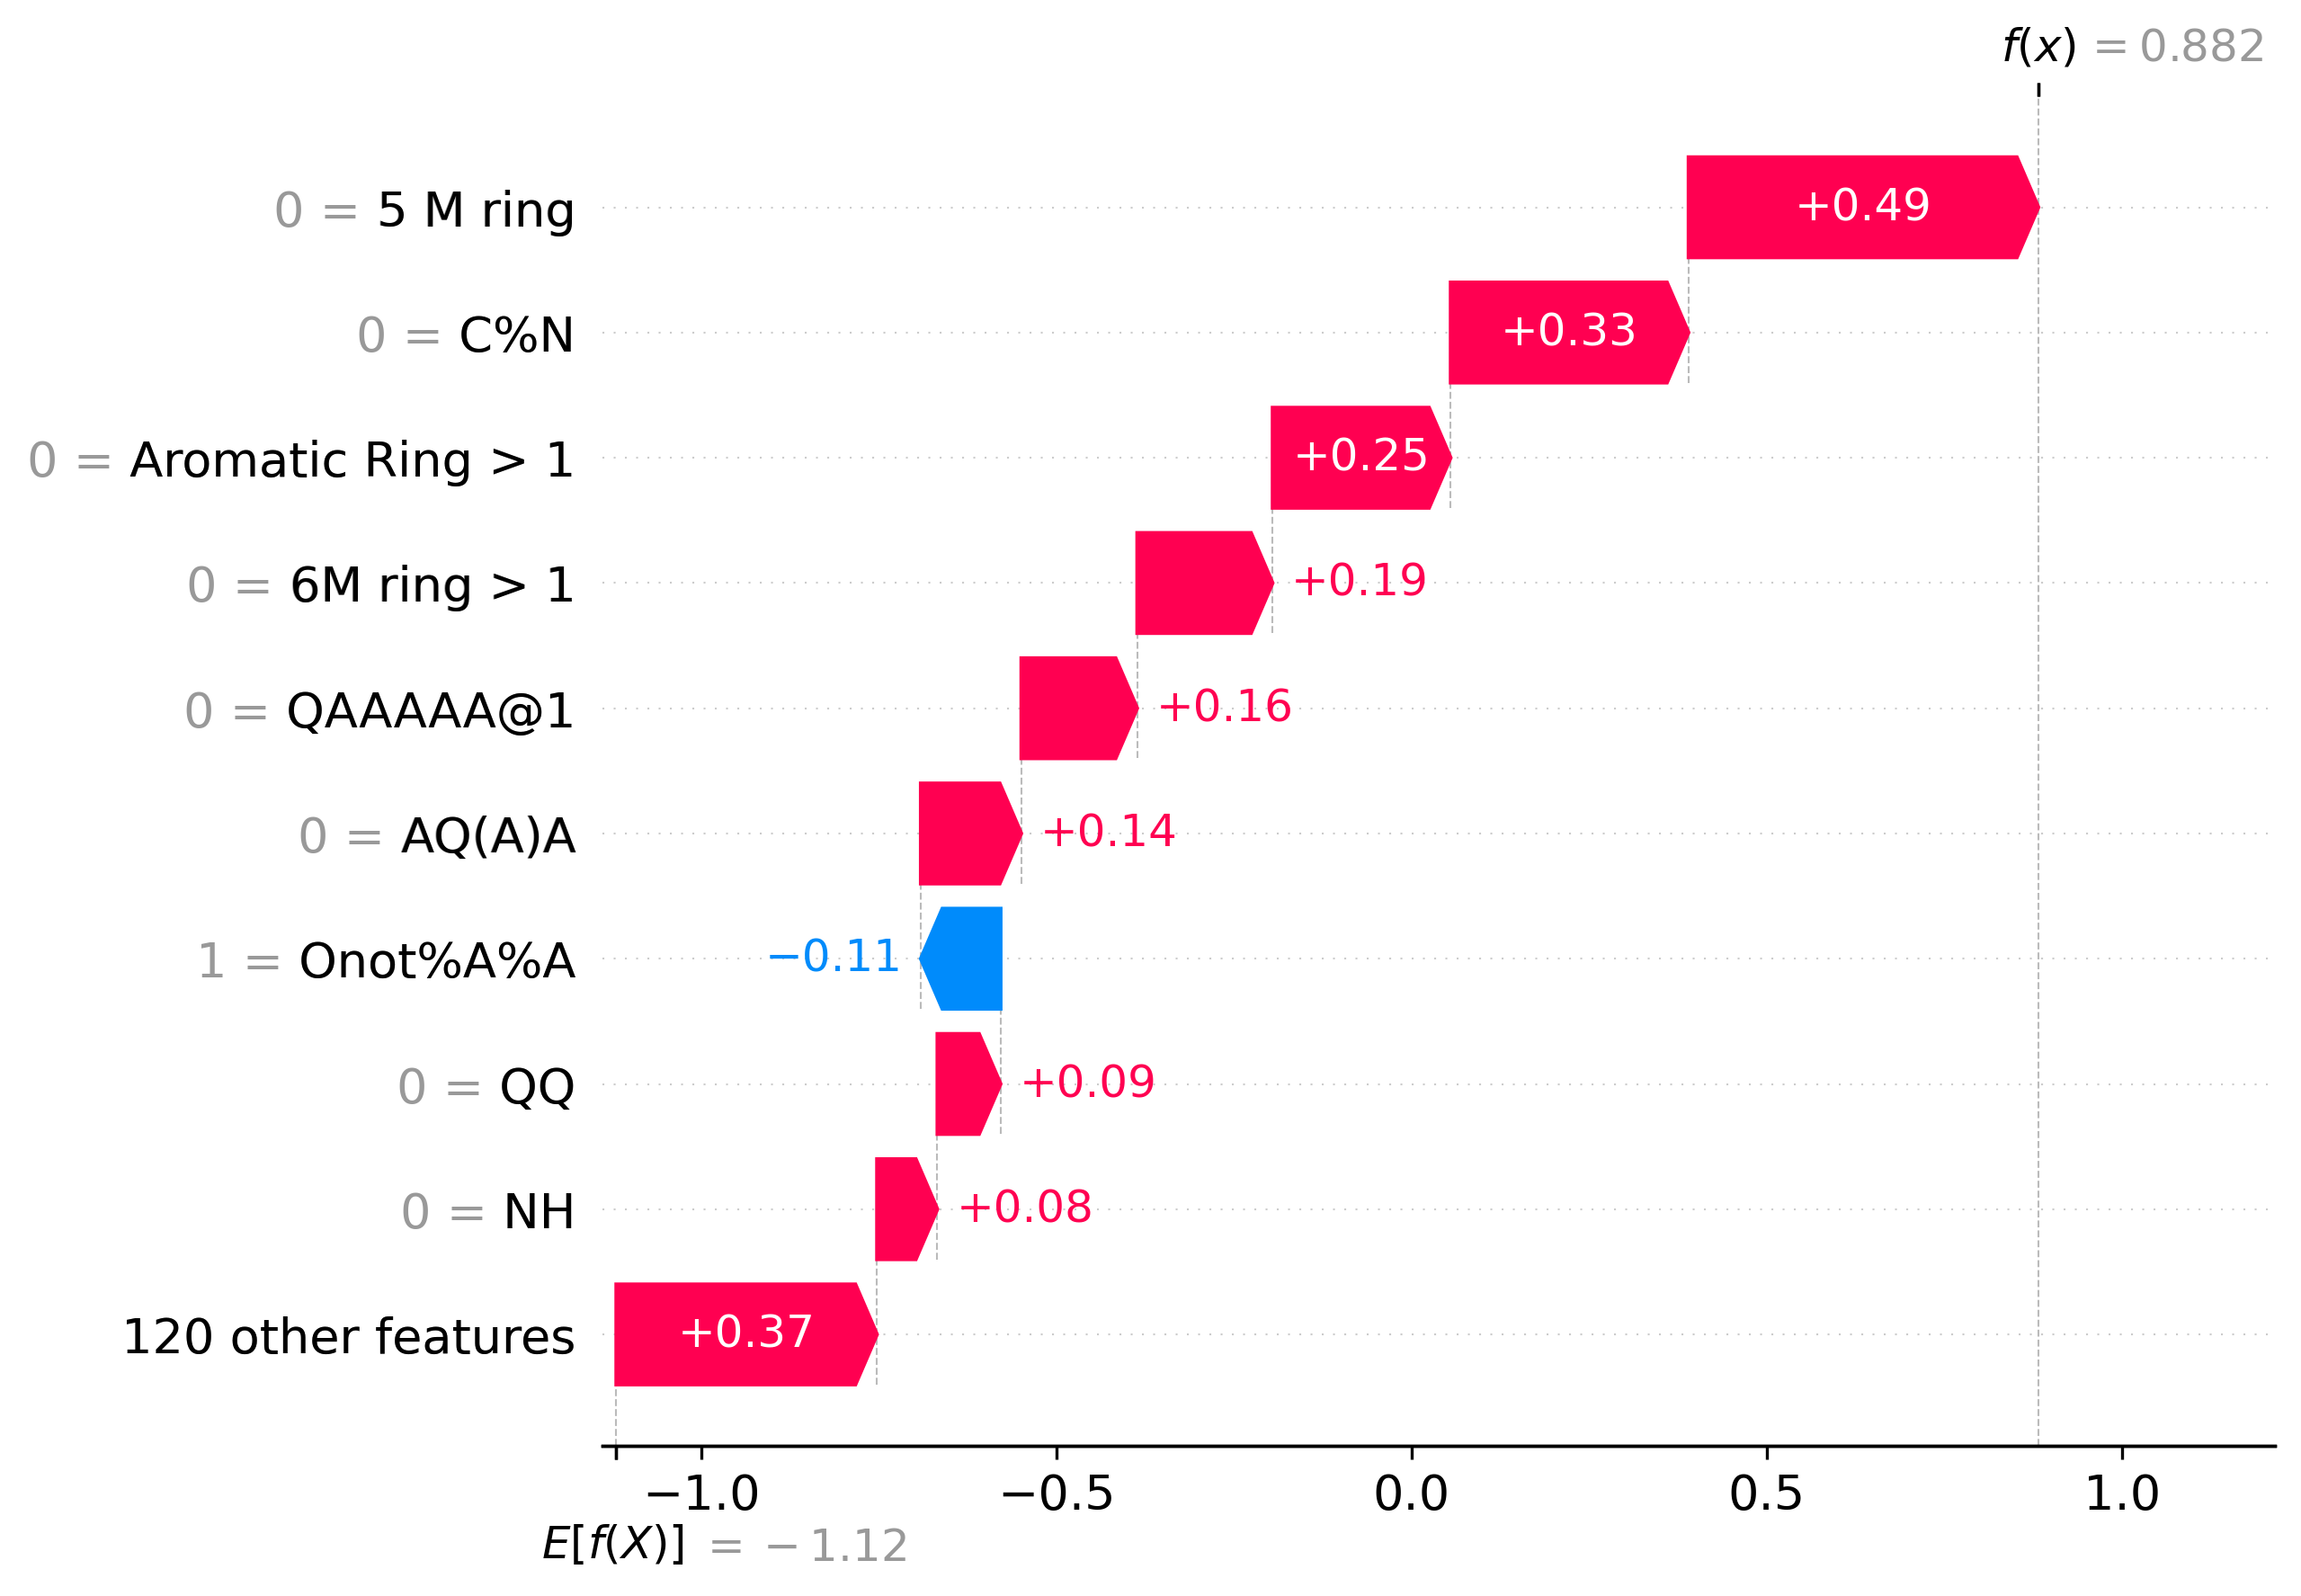

In [72]:
shap.plots.waterfall(shap_exp[0])

# Safranal

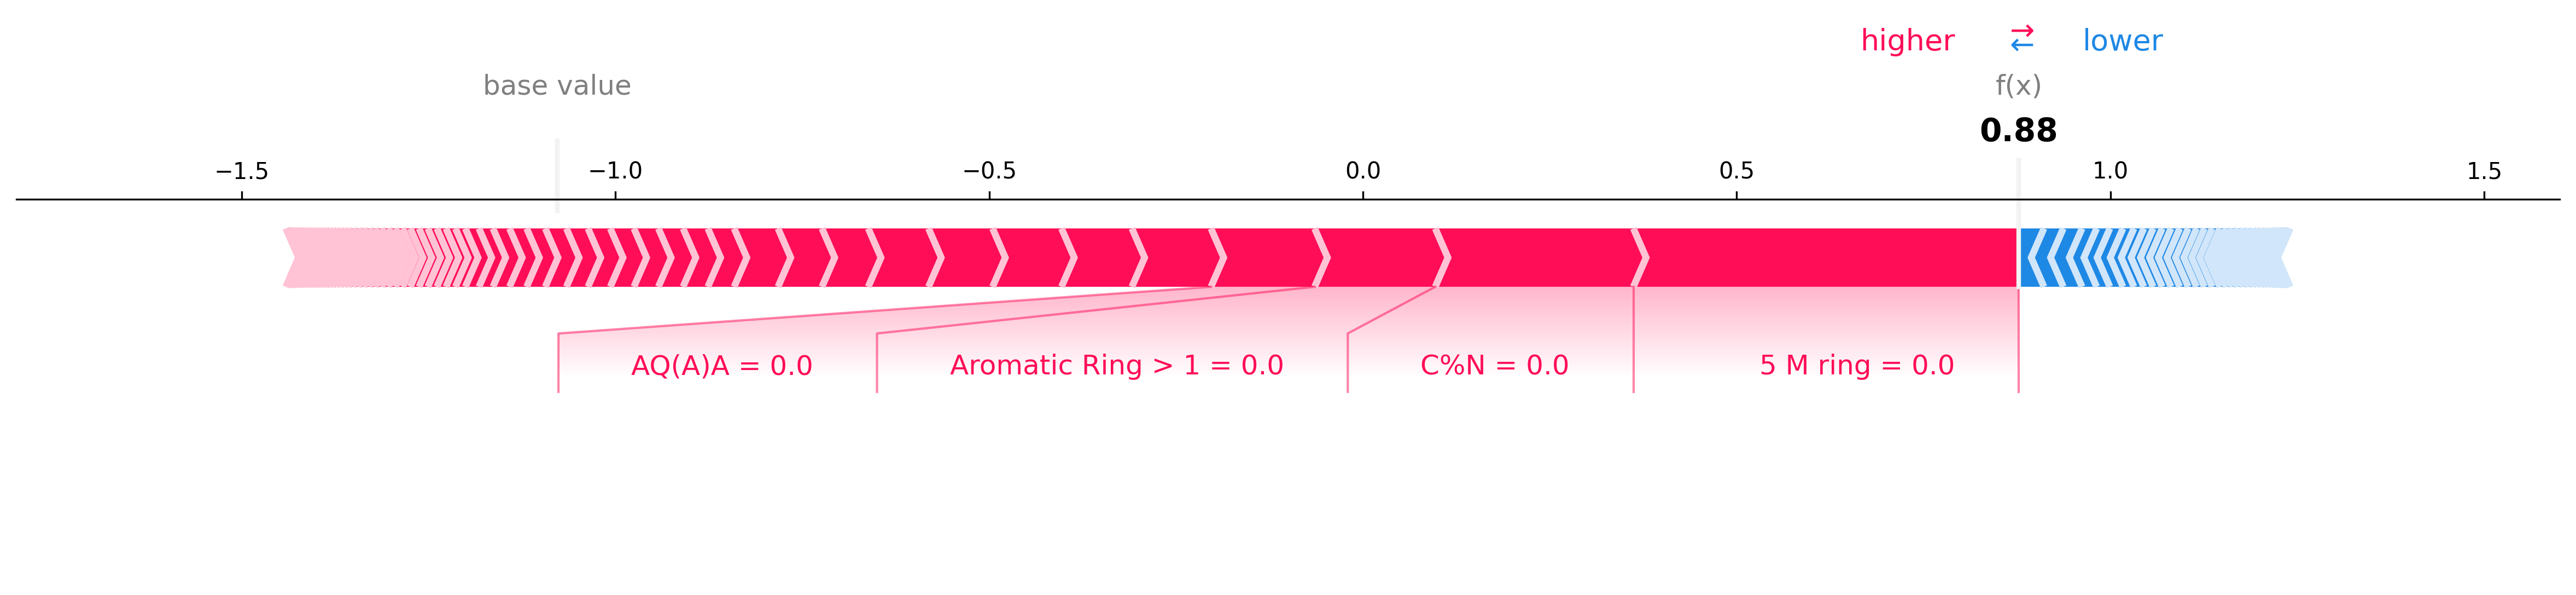

In [65]:
sample = 1  
shap.initjs()
shap.force_plot(
    shap_exp.base_values[sample], 
    shap_exp.values[sample], 
    shap_exp.data[sample], 
    feature_names=result,
    matplotlib=True
)

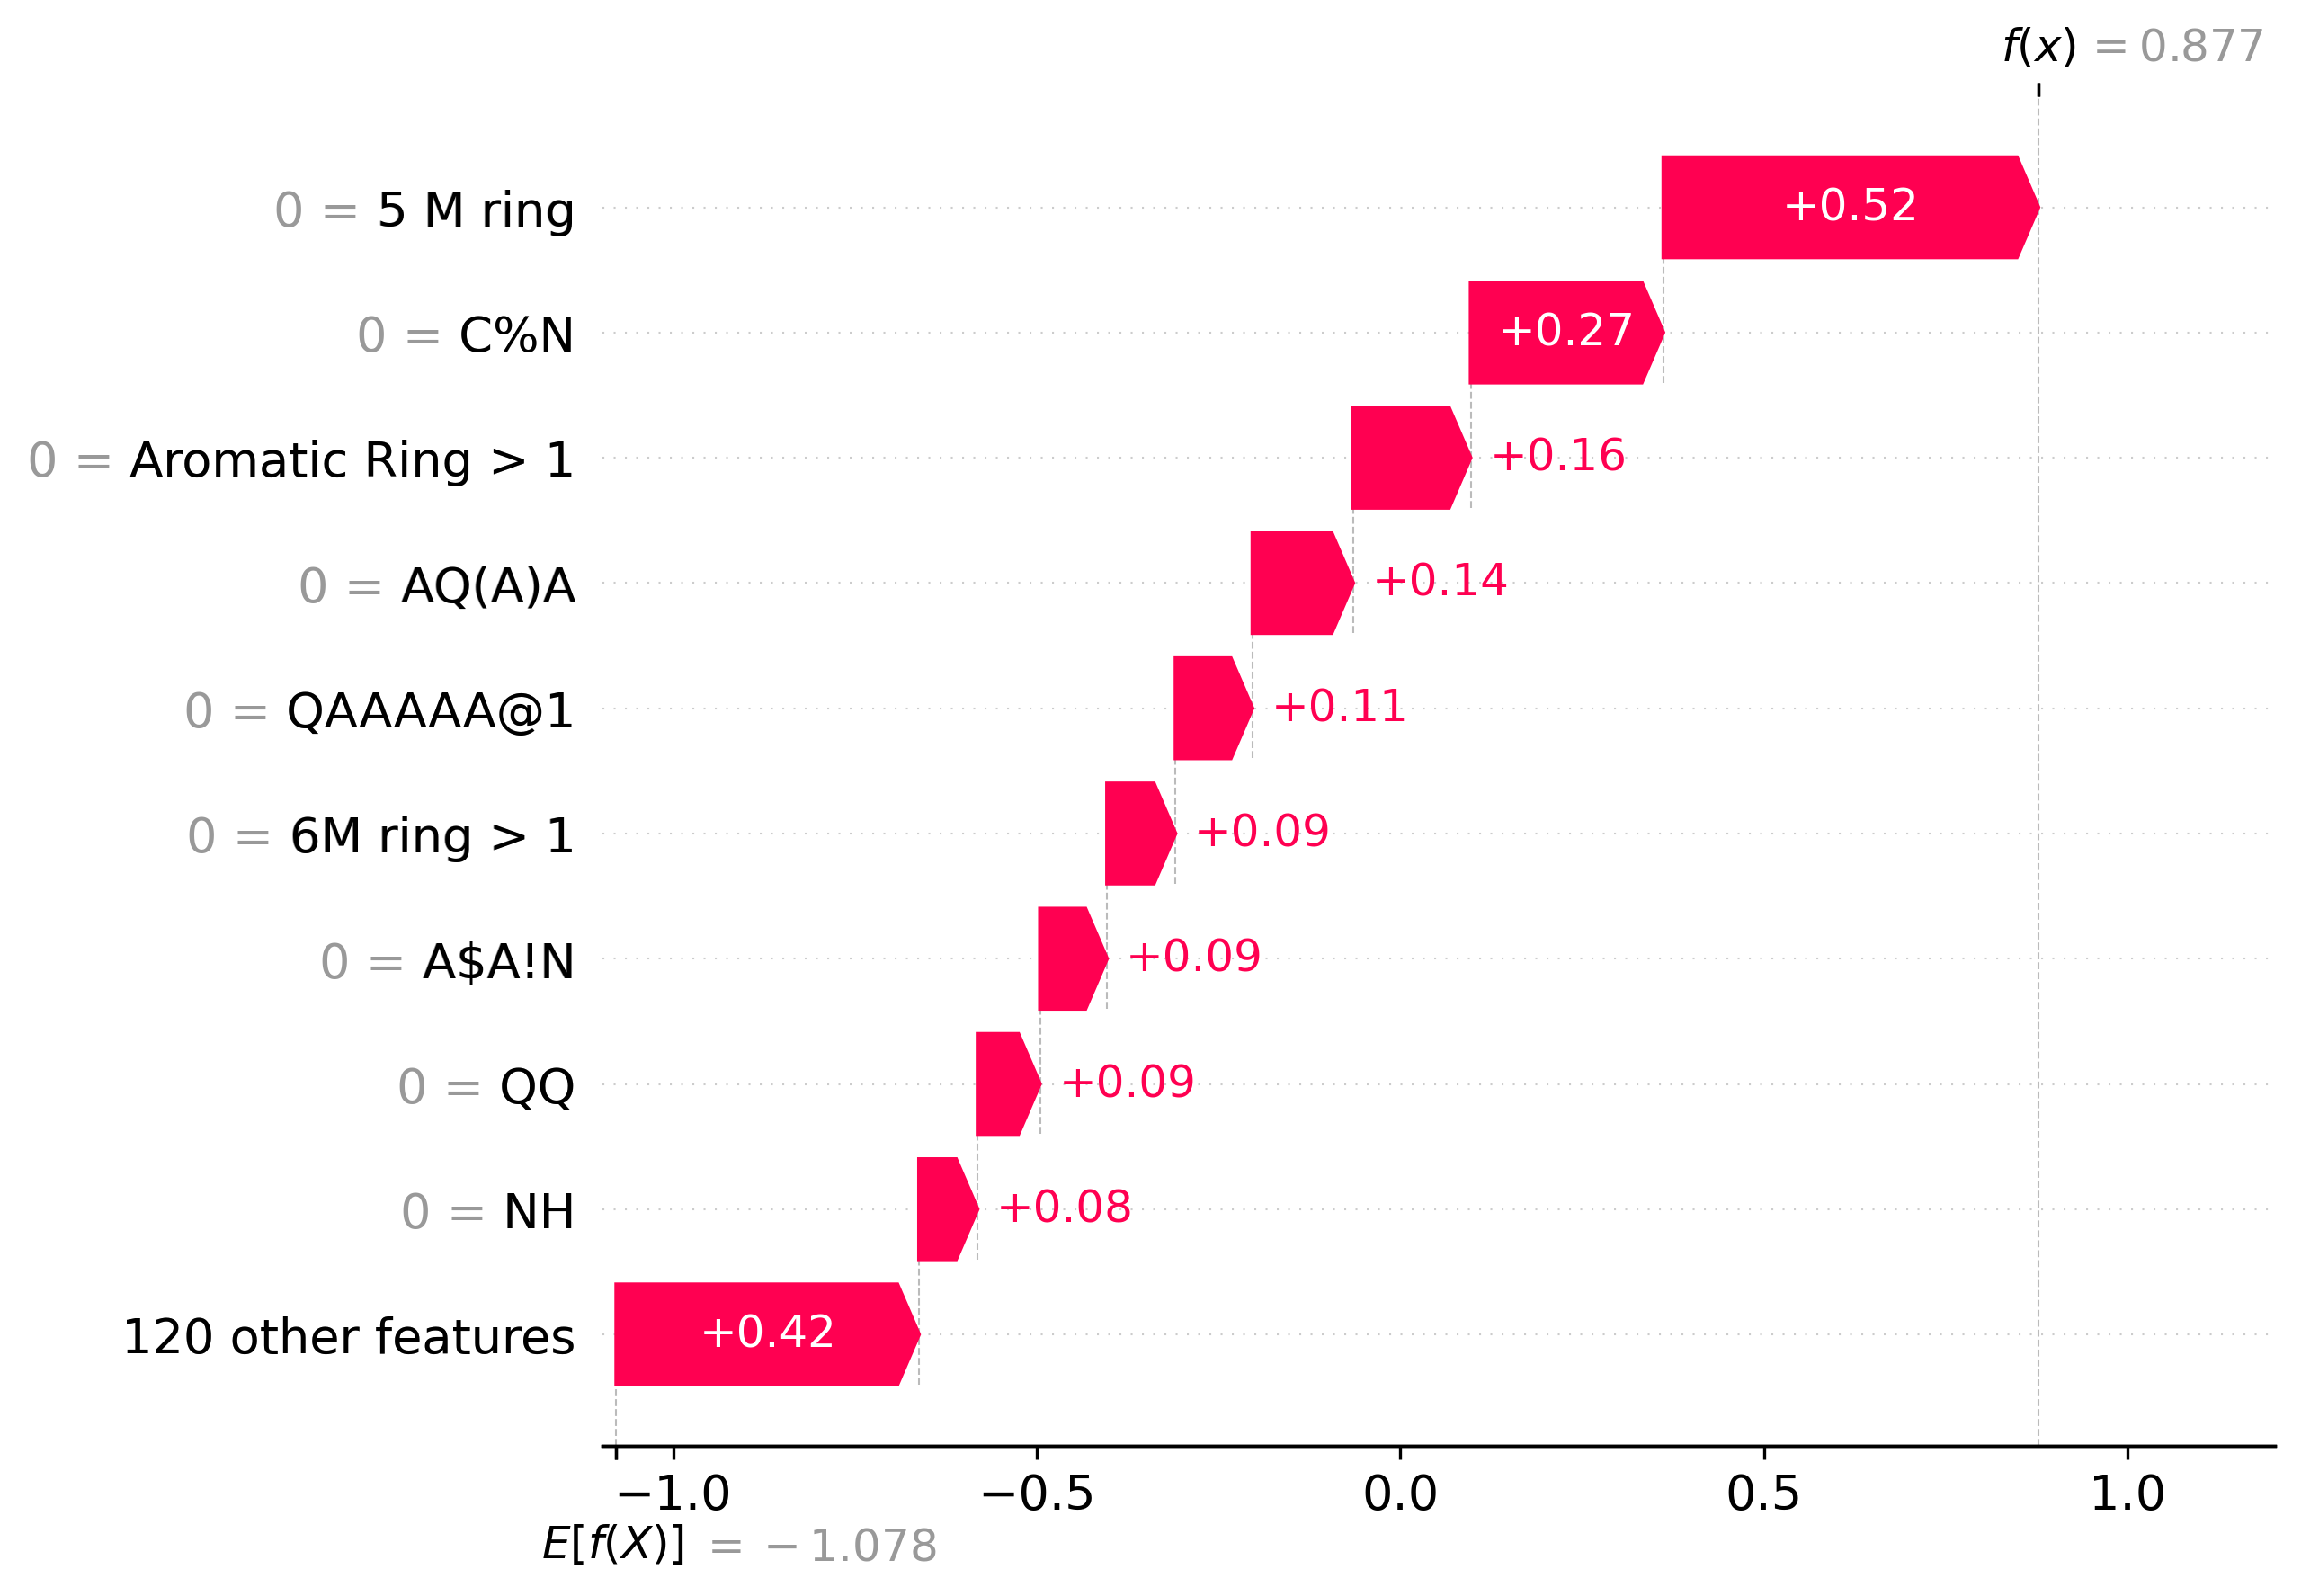

In [66]:
shap.plots.waterfall(shap_exp[1])

# Vanillin

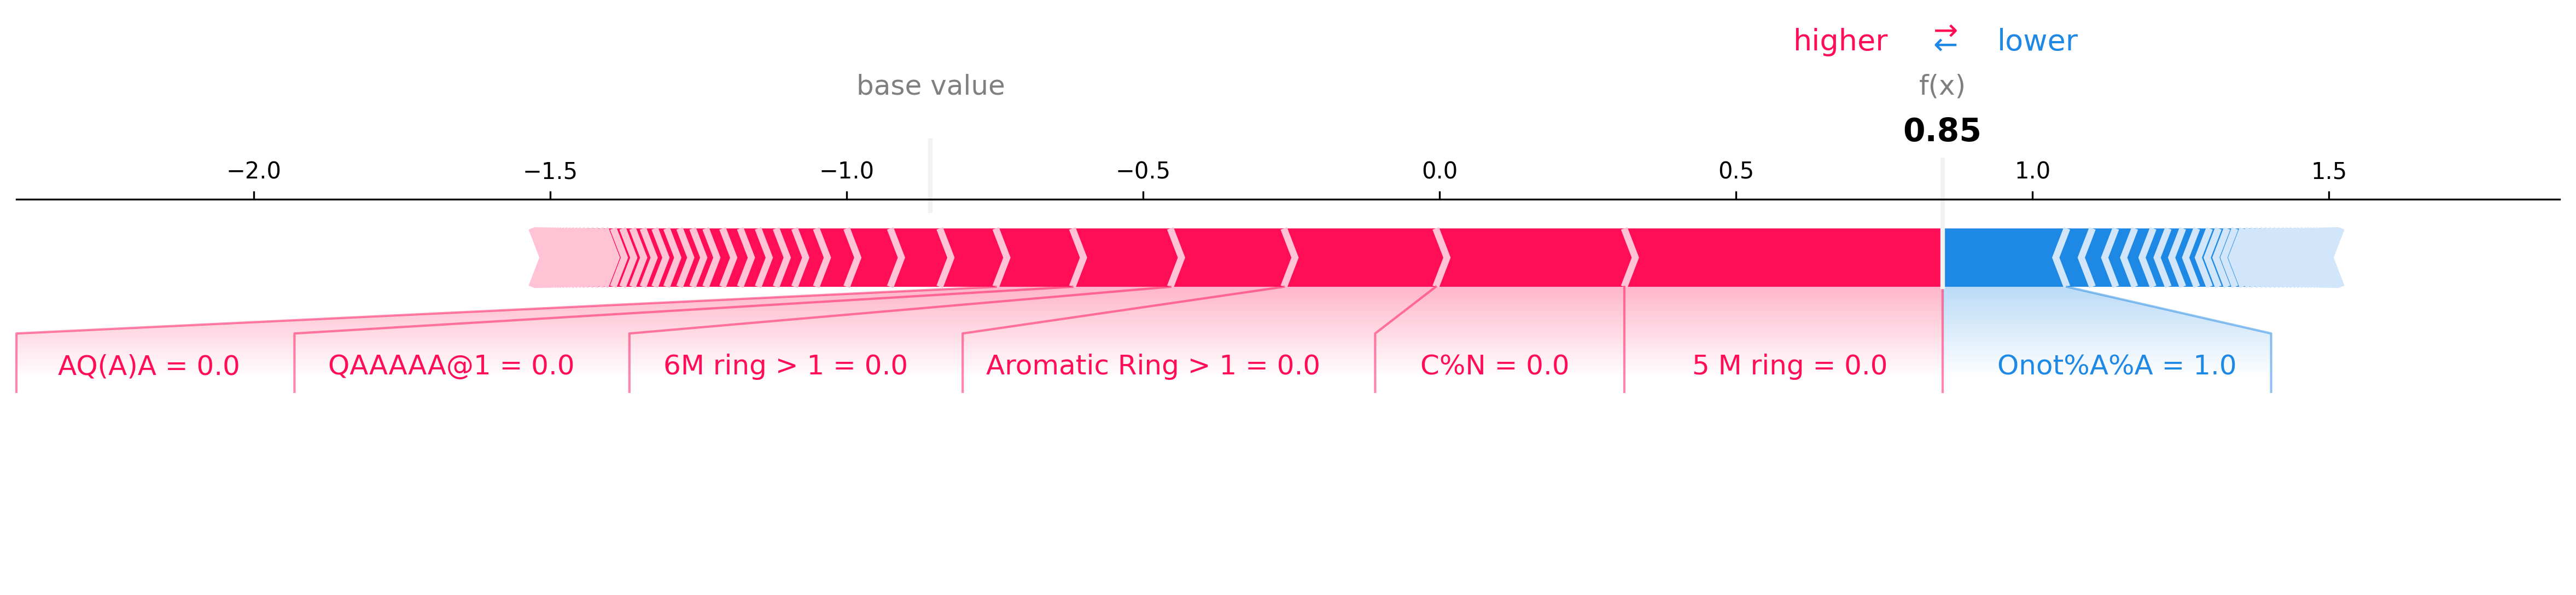

In [67]:
sample = 2  
shap.initjs()
shap.force_plot(
    shap_exp.base_values[sample], 
    shap_exp.values[sample], 
    shap_exp.data[sample], 
    feature_names=result,
    matplotlib=True
)

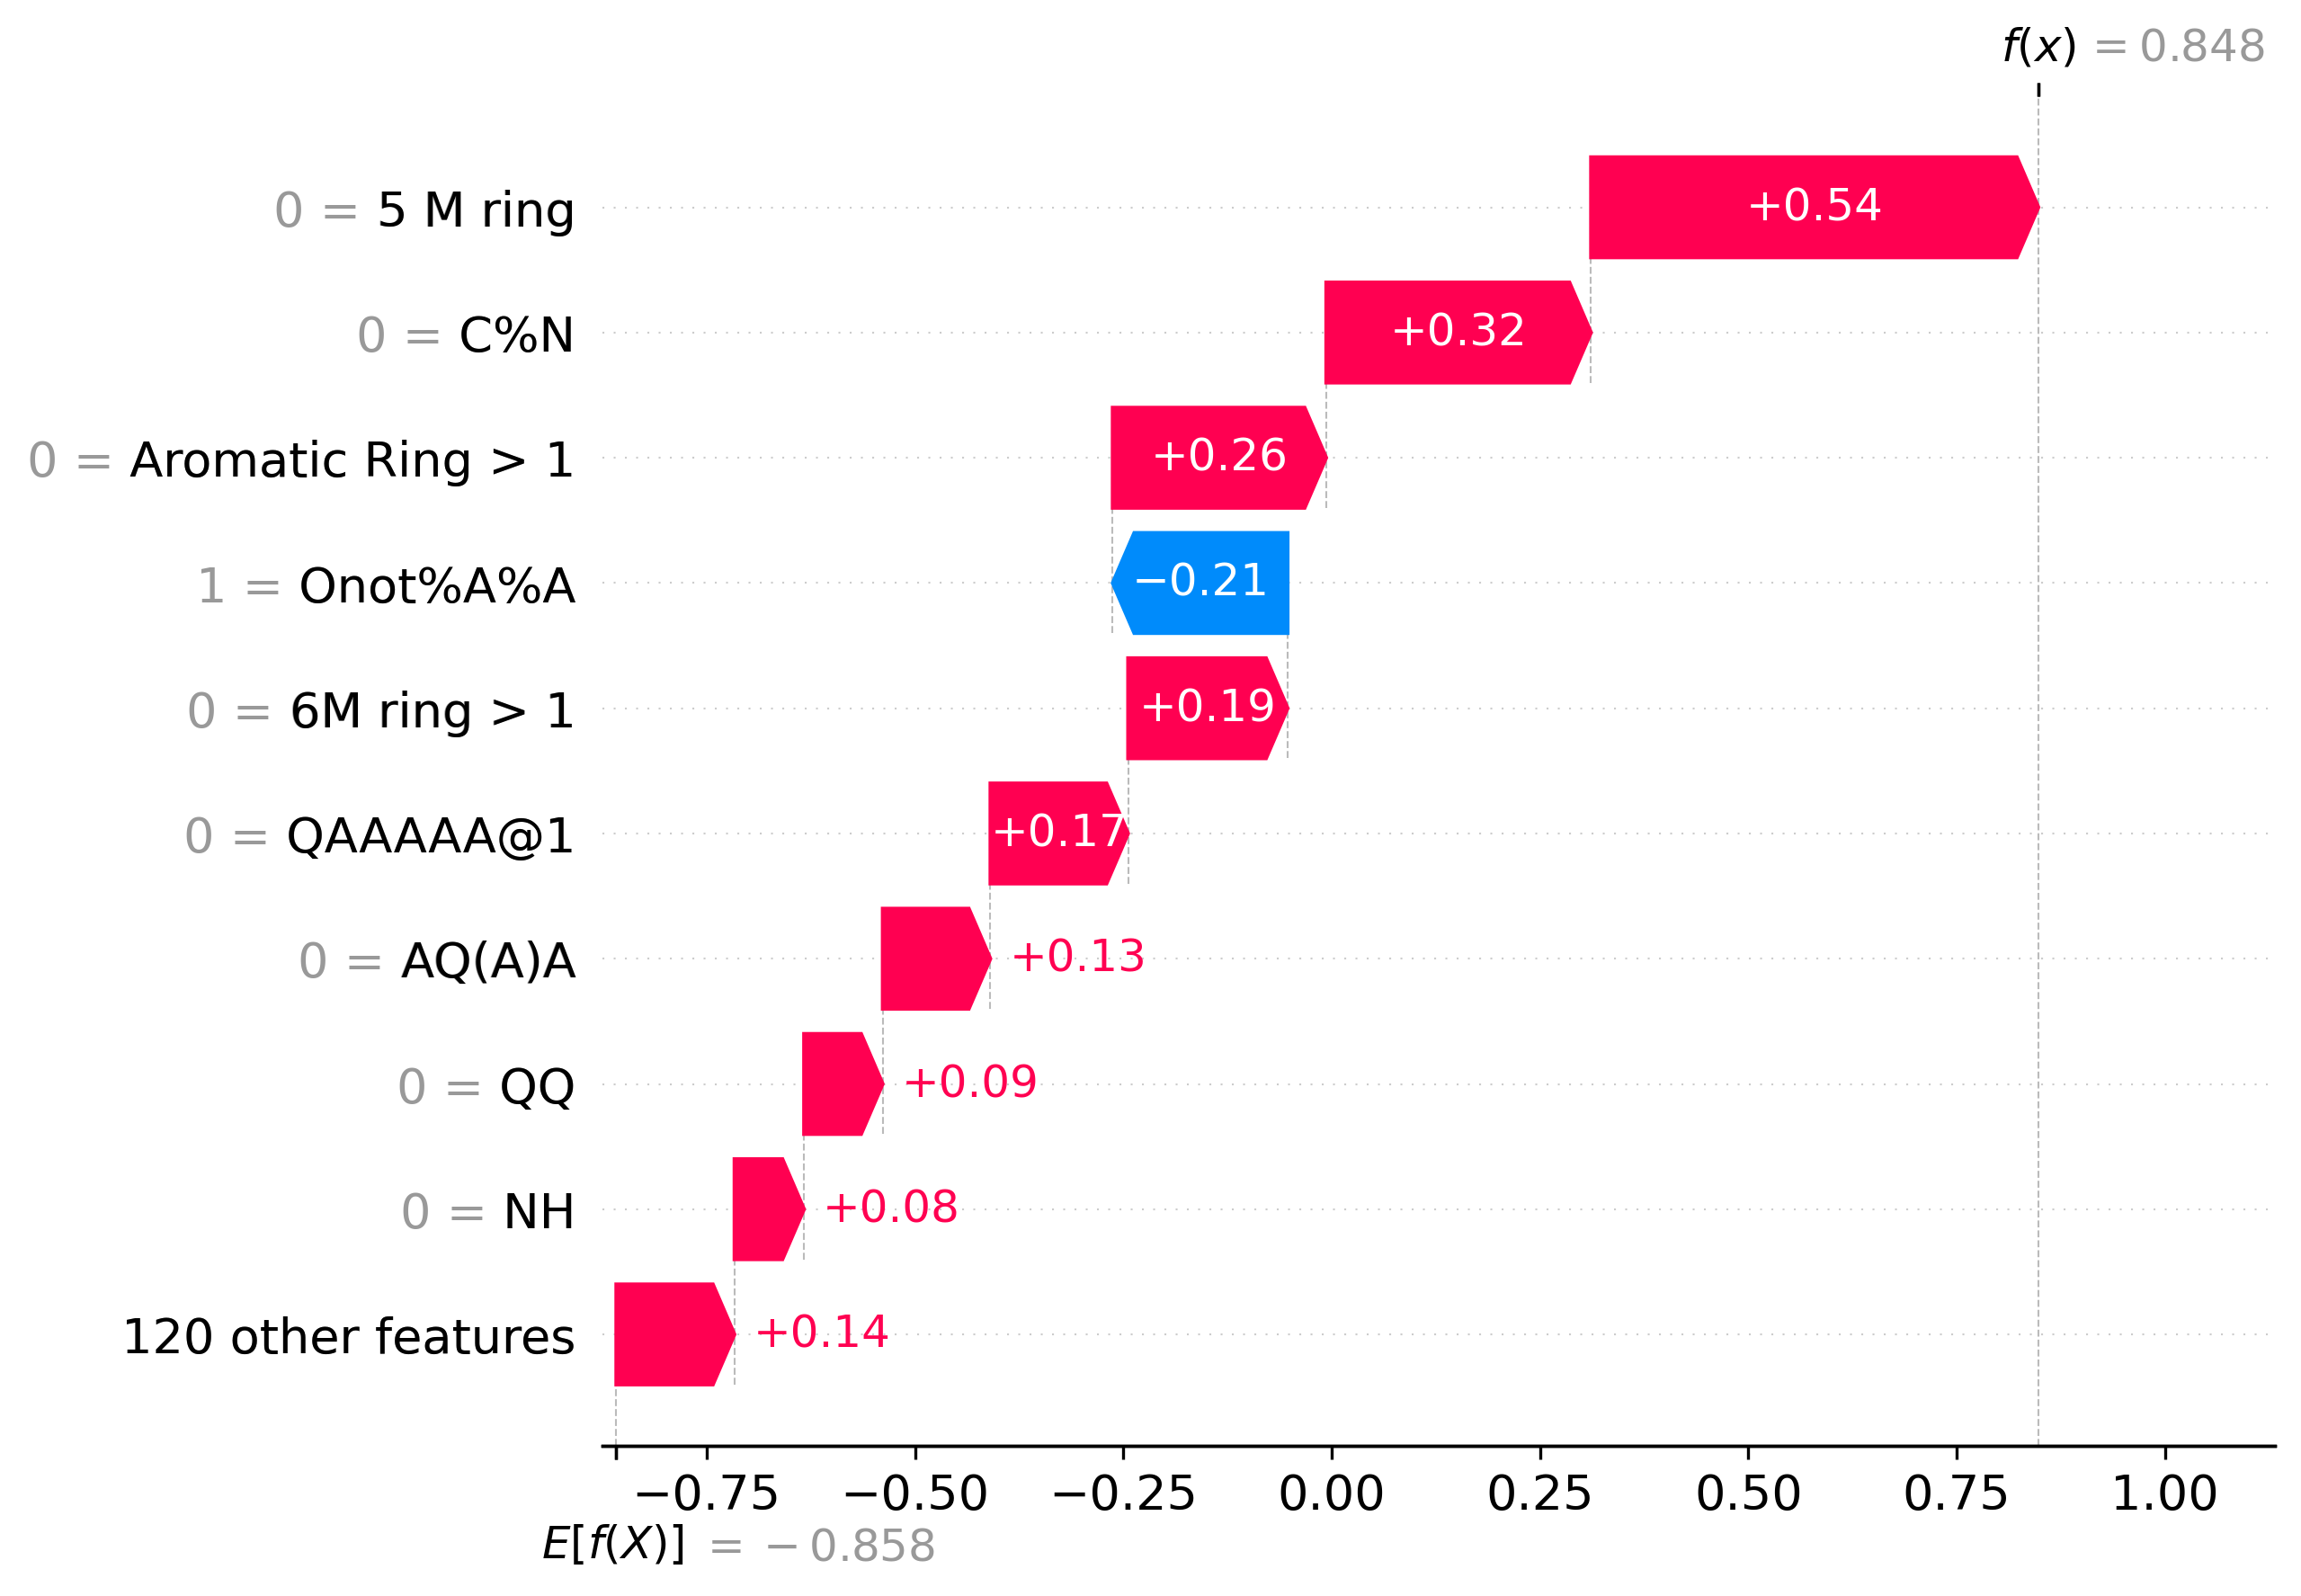

In [68]:
shap.plots.waterfall(shap_exp[2])

# Methyleugenol

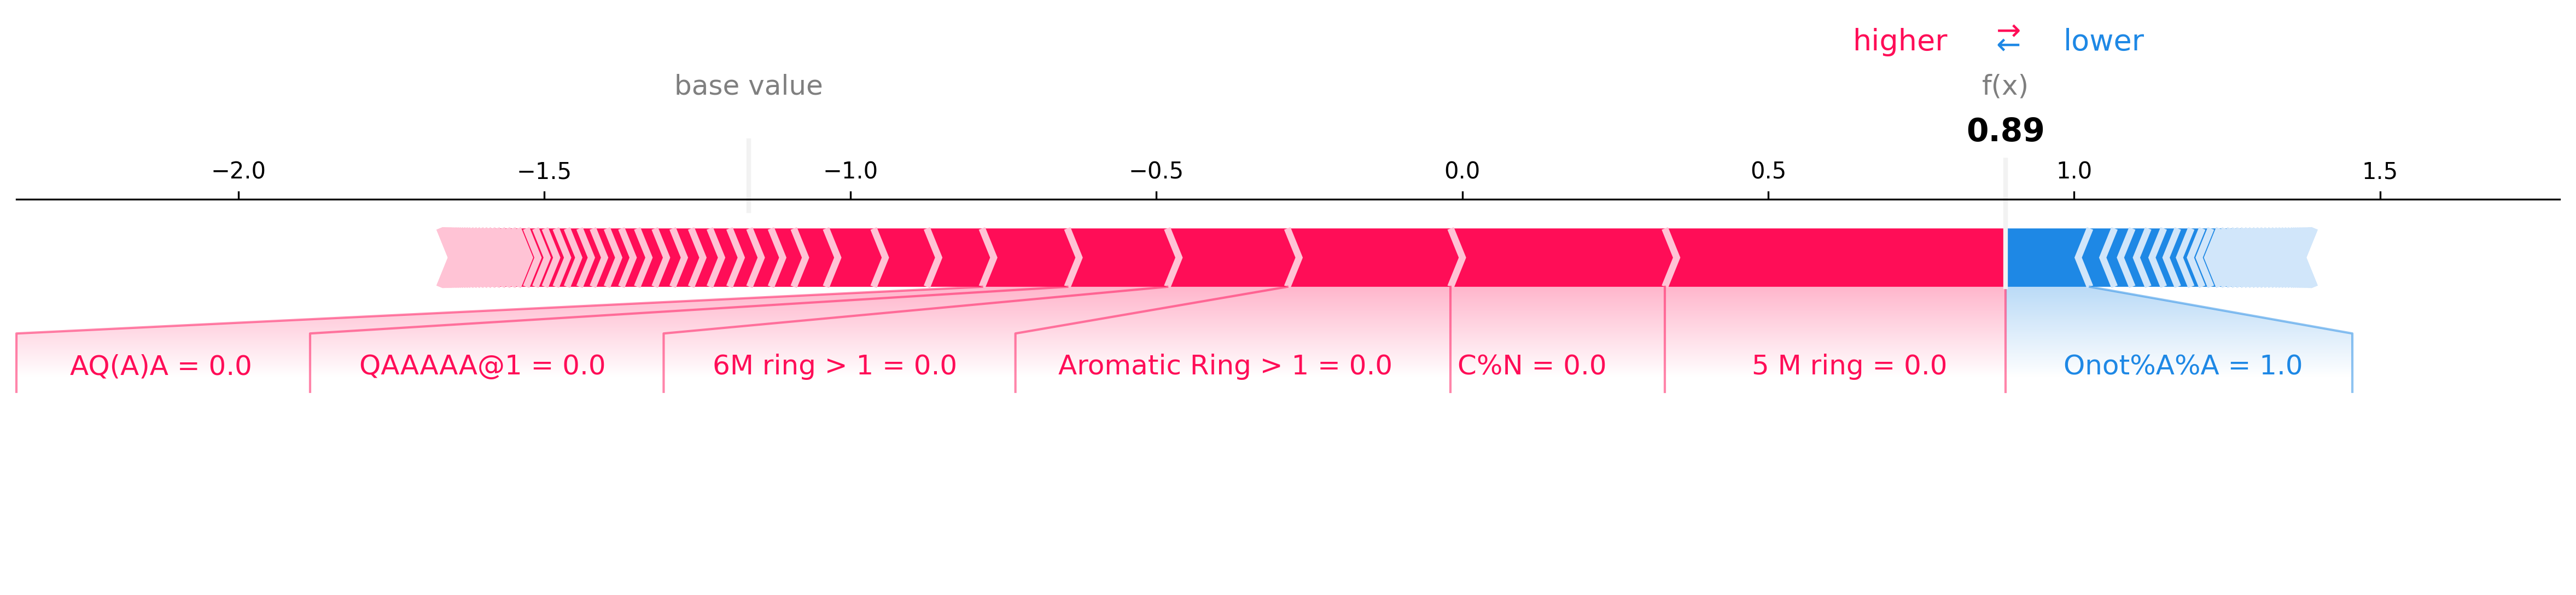

In [69]:
sample = 3  
shap.initjs()
shap.force_plot(
    shap_exp.base_values[sample], 
    shap_exp.values[sample], 
    shap_exp.data[sample], 
    feature_names=result,
    matplotlib=True
)

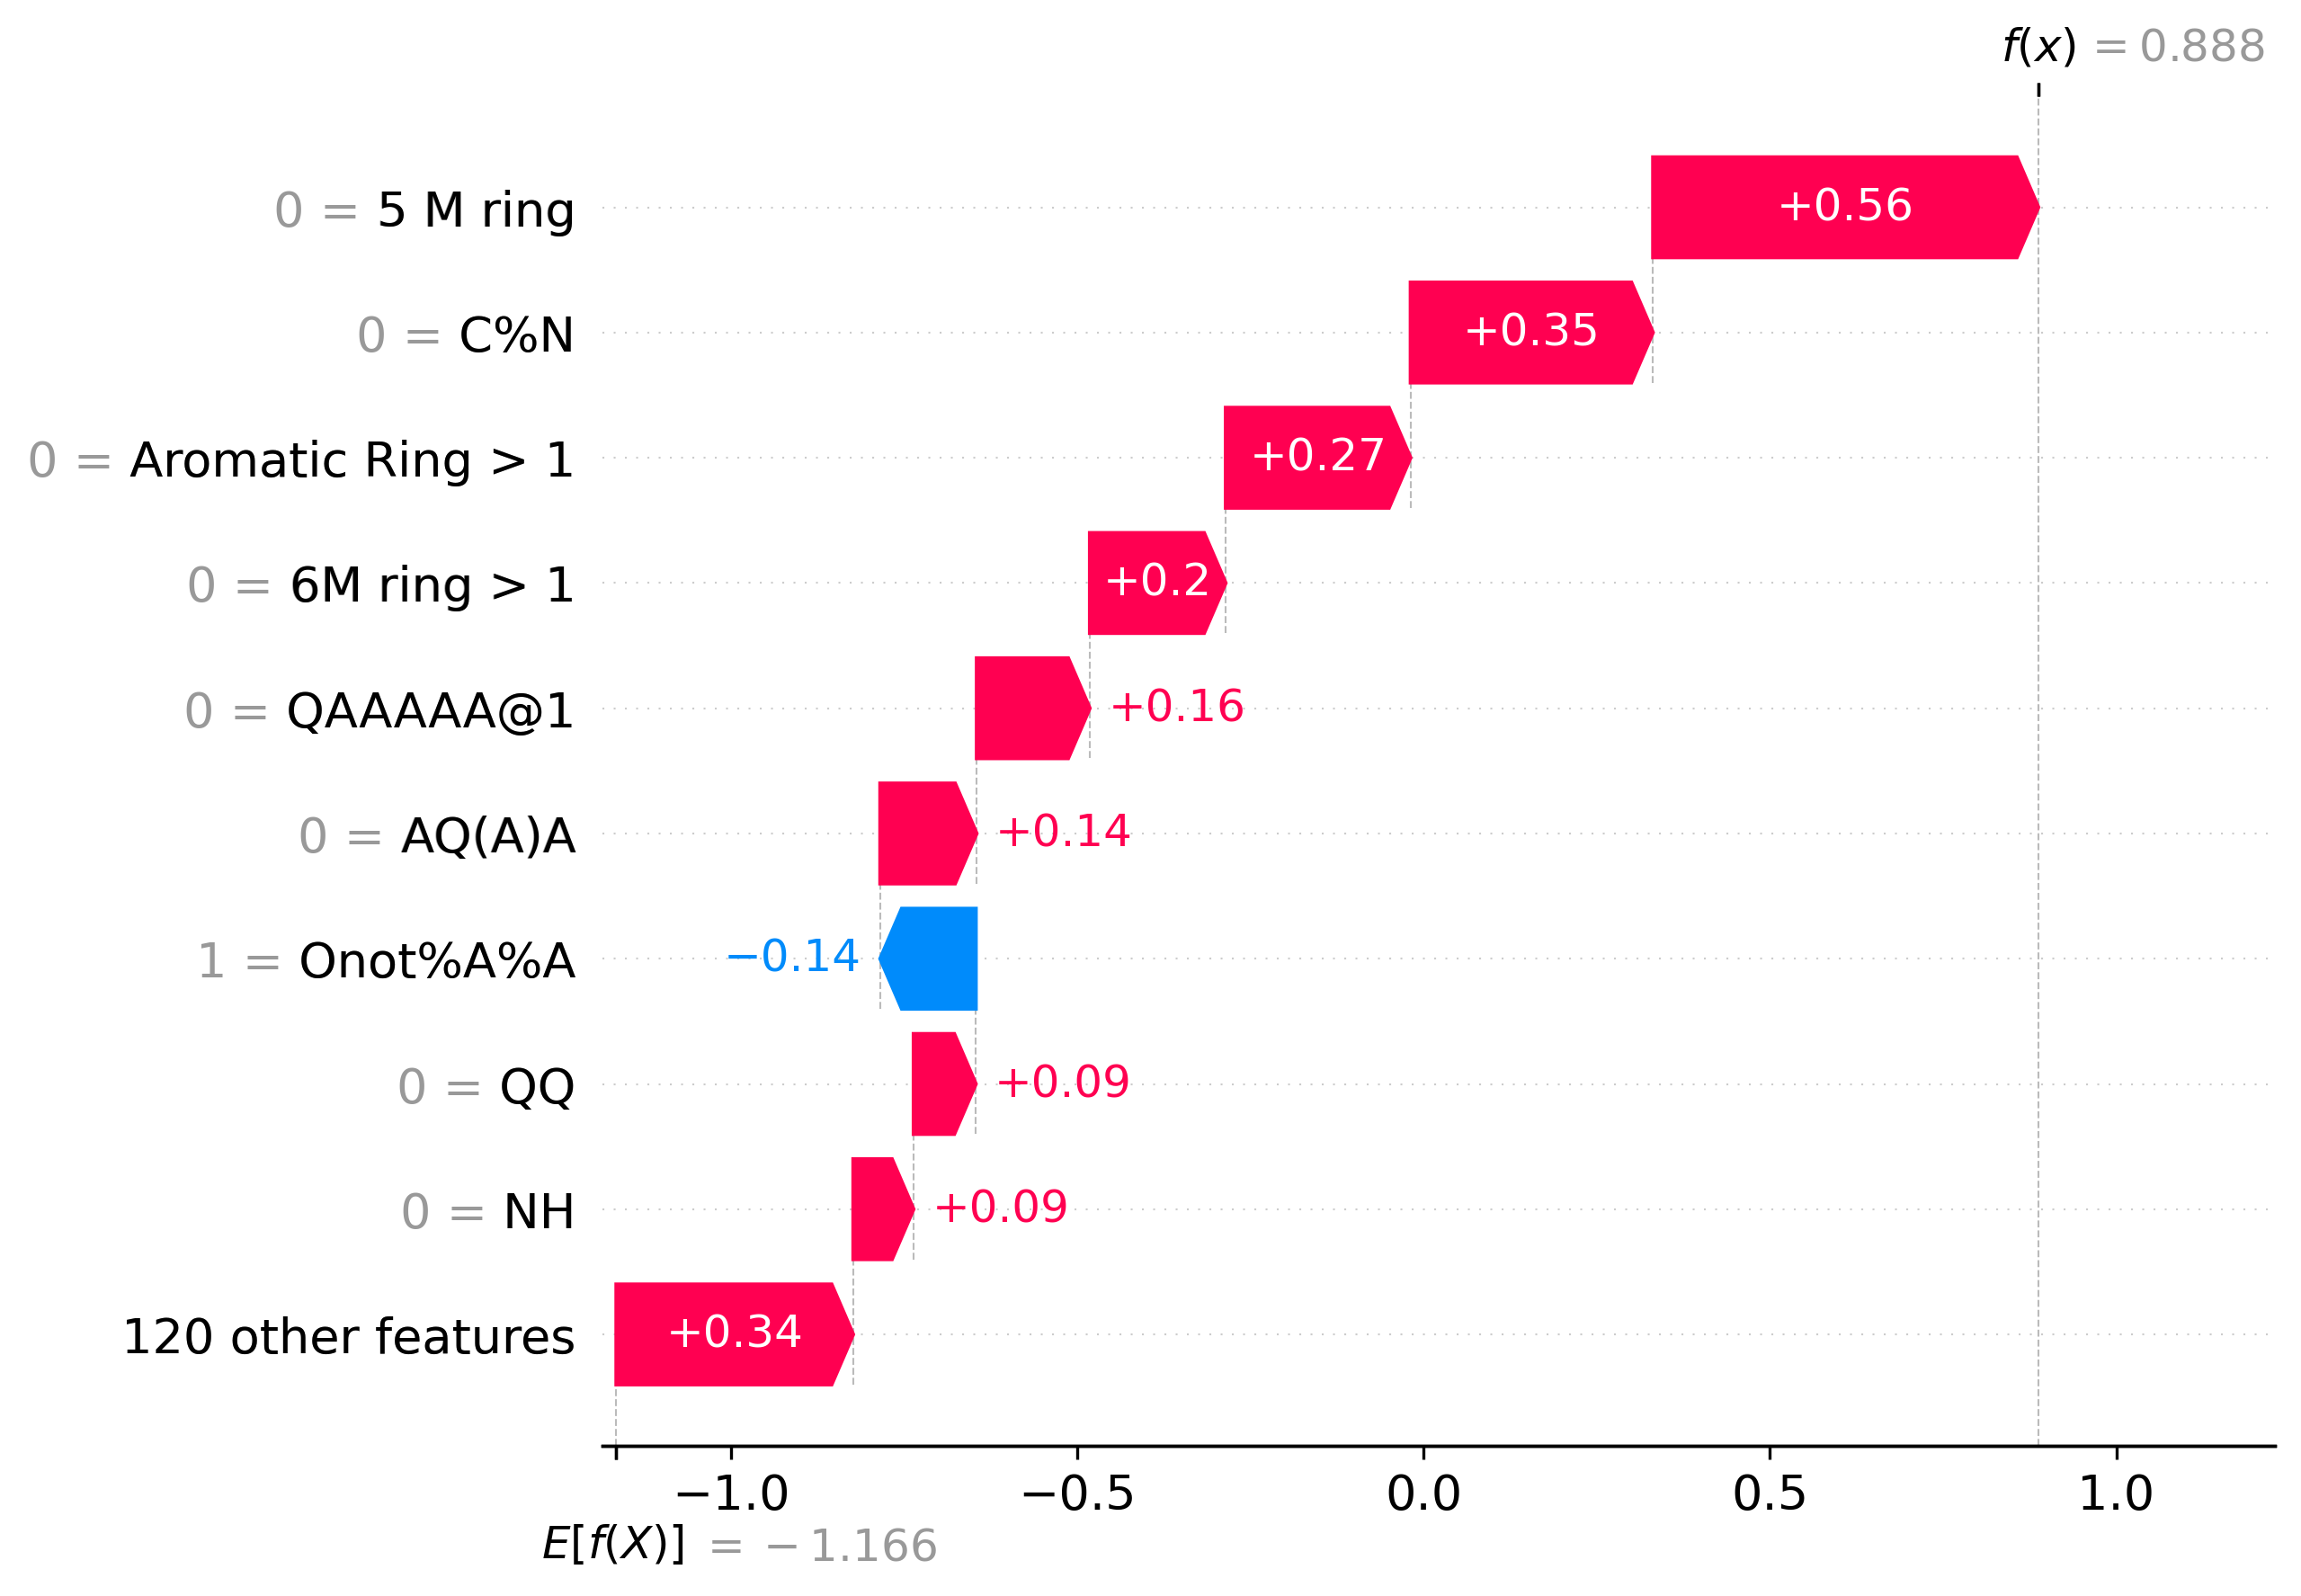

In [70]:
shap.plots.waterfall(shap_exp[3])